# Cart Pole - V1


In [56]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb
from joblib import Parallel, delayed

env = gym.make('CartPole-v1')

In [2]:
class Tiling:
  def __init__(self, env, numTilings=8, numTiles=10):
    self.numTilings = numTilings
    self.numTiles = numTiles

    state, _ = env.reset()

    # Define limits
    cart_position_limit = 4.8
    pole_angle_limit = (24 * np.pi) / 180  # 24 degrees in radians
    cart_velocity_limit = 10
    pole_angular_velocity_limit = np.pi  # 3.1416 rad/s

    # Define low, high limits
    self.low = np.array([-cart_position_limit, -cart_velocity_limit, -pole_angle_limit, -pole_angular_velocity_limit])
    self.high = np.array([cart_position_limit, cart_velocity_limit, pole_angle_limit, pole_angular_velocity_limit])

    # Define offsets for tilings
    self.offsets = [
        (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
        for low, high in zip(self.low, self.high)
    ]

    # Create tilings
    self.tilings = self.createTilings()

  def getTilings(self):
    return self.tilings

  def createTilingGrid(self, low, high, bins, offsets):
    """ Create a single tiling grid """
    return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

  def createTilings(self):
    """ Create multiple tiling grids with offsets """
    tilings = []
    for i in range(self.numTilings):
        offsets_i = [offset[i] for offset in self.offsets]  # Pick correct offset for each tiling
        tilings.append(self.createTilingGrid(self.low, self.high, self.numTiles, offsets_i))
    return tilings

  def discretize(self, state):
    """ Convert continuous state into discrete indices across all tilings """
    discretized_indices = []
    for tiling in self.tilings:
        tile_indices = []
        for dim, bins in enumerate(tiling):
            tile_indices.append(np.digitize(state[dim], bins))  # Assign bin index for each dimension
        discretized_indices.append(tuple(tile_indices))
    return discretized_indices

In [14]:
class sarsaAgent:
  def __init__(self,env,alpha=0.1,gamma=0.99,epsilon_start=1.0,epsilon_decay=0.995,epsilon_min=0.0001,numTilings=2,numTiles=5,log_wandb=False):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon_start
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.numTilings = numTilings
    self.numTiles = numTiles
    self.log_wandb = log_wandb

    self.tiling = Tiling(env,numTilings,numTiles)
    self.numActions = self.env.action_space.n

    # Define feature representation using tile coding
    self.numFeatures = self.numTilings * self.numTiles** 4
    self.weights = np.zeros((self.numActions, self.numFeatures))  # Weights for each action

  def featureVector(self, state, action):
    """ Convert a continuous state into a binary feature vector. """
    discretized_indices = self.tiling.discretize(state)
    featureVector = np.zeros(self.numTilings * self.numTiles**4)

    for i, ds in enumerate(discretized_indices):
        index = sum(ds[d] * (self.numTiles**d) for d in range(len(ds)))  # Multi-dim index
        feature_index = i * self.numTiles**4 + index
        featureVector[feature_index] = 1  # Activate feature

    return featureVector

  def getQvalues(self,state,action):
    """ Approximates Q(s, a) = θ^T * φ(s, a) """
    featureVector = self.featureVector(state,action)
    return np.dot(self.weights[action], featureVector)

  def choose_epsilonGreedy_action(self,state):
    """ Chooses an action using ε-greedy policy. """
    if np.random.rand() < self.epsilon:
        return self.env.action_space.sample()  # Random action
    else:
        q_values = [self.getQvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)  # Best action

  def update(self,state,action,reward,next_state,next_action):
    """ SARSA update rule with linear function approximation """
    phi = self.featureVector(state, action)
    q_sa = self.getQvalues(state, action)
    q_next = self.getQvalues(next_state, next_action)

    td_target = reward + self.gamma * q_next
    td_error = td_target - q_sa
    self.weights[action] += (self.alpha/self.numTilings) * td_error * phi

  def train(self,num_episodes):
    episode_rewards = np.zeros(num_episodes)
    steps_to_completion = np.zeros(num_episodes)

    for i in tqdm(range(num_episodes)):
      totalReward = 0
      steps = 0

      state,_ = self.env.reset() #resetting the environment
      action = self.choose_epsilonGreedy_action(state)
      done = False

      while not done:
        next_state,reward,terminated,truncated,info = self.env.step(action)
        next_action = self.choose_epsilonGreedy_action(next_state)

        # Update weights using SARSA
        self.update(state, action, reward, next_state, next_action)

        state = next_state
        action = next_action

        totalReward += reward
        steps+=1

        done = terminated or truncated


      episode_rewards[i] = totalReward
      steps_to_completion[i] = steps

      #epsilon decay
      self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

      if i % 100 == 99:
        wandb.log({"episode": i+1, "episodic_return": episode_rewards[i]})
        avg_reward = np.mean(episode_rewards[max(0, i-100):i+1])
        print(f"Episode {i+1}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {self.epsilon:.4f}")

    return episode_rewards,steps_to_completion


In [ ]:
# Example usage
env = gym.make("CartPole-v1")
agent = sarsaAgent(env)
agent.train(num_episodes=2000)

  1%|          | 14/2000 [00:00<00:15, 132.11it/s]

Episode 0/2000, Avg Reward (Last 50): 18.00, Epsilon: 0.9950


  4%|▎         | 71/2000 [00:00<00:16, 113.68it/s]

Episode 50/2000, Avg Reward (Last 50): 29.80, Epsilon: 0.7744


  6%|▌         | 112/2000 [00:01<00:27, 69.62it/s]

Episode 100/2000, Avg Reward (Last 50): 48.18, Epsilon: 0.6027


  8%|▊         | 155/2000 [00:02<00:45, 40.98it/s]

Episode 150/2000, Avg Reward (Last 50): 72.59, Epsilon: 0.4691


 10%|█         | 207/2000 [00:04<01:04, 27.66it/s]

Episode 200/2000, Avg Reward (Last 50): 110.69, Epsilon: 0.3651


 13%|█▎        | 253/2000 [00:06<01:16, 22.93it/s]

Episode 250/2000, Avg Reward (Last 50): 131.08, Epsilon: 0.2842


 15%|█▌        | 302/2000 [00:08<02:21, 11.98it/s]

Episode 300/2000, Avg Reward (Last 50): 160.25, Epsilon: 0.2212


 18%|█▊        | 353/2000 [00:12<01:00, 27.31it/s]

Episode 350/2000, Avg Reward (Last 50): 158.45, Epsilon: 0.1721


 20%|██        | 403/2000 [00:15<01:42, 15.53it/s]

Episode 400/2000, Avg Reward (Last 50): 206.06, Epsilon: 0.1340


 23%|██▎       | 453/2000 [00:19<02:07, 12.15it/s]

Episode 450/2000, Avg Reward (Last 50): 217.10, Epsilon: 0.1043


 25%|██▌       | 503/2000 [00:24<03:03,  8.17it/s]

Episode 500/2000, Avg Reward (Last 50): 253.02, Epsilon: 0.0812


 28%|██▊       | 552/2000 [00:29<02:25,  9.94it/s]

Episode 550/2000, Avg Reward (Last 50): 289.16, Epsilon: 0.0632


 30%|███       | 602/2000 [00:33<02:20,  9.97it/s]

Episode 600/2000, Avg Reward (Last 50): 247.45, Epsilon: 0.0492


 33%|███▎      | 653/2000 [00:39<02:20,  9.57it/s]

Episode 650/2000, Avg Reward (Last 50): 305.67, Epsilon: 0.0383


 35%|███▌      | 702/2000 [00:43<02:31,  8.56it/s]

Episode 700/2000, Avg Reward (Last 50): 229.57, Epsilon: 0.0298


 38%|███▊      | 752/2000 [00:50<02:39,  7.83it/s]

Episode 750/2000, Avg Reward (Last 50): 308.84, Epsilon: 0.0232


 40%|████      | 802/2000 [00:55<02:40,  7.45it/s]

Episode 800/2000, Avg Reward (Last 50): 336.98, Epsilon: 0.0180


 43%|████▎     | 852/2000 [01:04<02:58,  6.45it/s]

Episode 850/2000, Avg Reward (Last 50): 398.02, Epsilon: 0.0140


 45%|████▌     | 902/2000 [01:11<02:45,  6.62it/s]

Episode 900/2000, Avg Reward (Last 50): 393.31, Epsilon: 0.0109


 48%|████▊     | 952/2000 [01:19<02:56,  5.93it/s]

Episode 950/2000, Avg Reward (Last 50): 429.69, Epsilon: 0.0085


 50%|█████     | 1001/2000 [01:27<01:56,  8.55it/s]

Episode 1000/2000, Avg Reward (Last 50): 420.08, Epsilon: 0.0066


 53%|█████▎    | 1052/2000 [01:33<01:50,  8.58it/s]

Episode 1050/2000, Avg Reward (Last 50): 330.67, Epsilon: 0.0052


 55%|█████▌    | 1101/2000 [01:38<01:27, 10.31it/s]

Episode 1100/2000, Avg Reward (Last 50): 240.90, Epsilon: 0.0040


 58%|█████▊    | 1152/2000 [01:44<02:04,  6.79it/s]

Episode 1150/2000, Avg Reward (Last 50): 318.96, Epsilon: 0.0031


 60%|██████    | 1201/2000 [01:52<02:21,  5.63it/s]

Episode 1200/2000, Avg Reward (Last 50): 419.39, Epsilon: 0.0024


 63%|██████▎   | 1253/2000 [01:59<01:36,  7.72it/s]

Episode 1250/2000, Avg Reward (Last 50): 415.27, Epsilon: 0.0019


 65%|██████▌   | 1302/2000 [02:08<01:42,  6.82it/s]

Episode 1300/2000, Avg Reward (Last 50): 446.00, Epsilon: 0.0015


 68%|██████▊   | 1352/2000 [02:15<01:19,  8.13it/s]

Episode 1350/2000, Avg Reward (Last 50): 413.96, Epsilon: 0.0011


 70%|███████   | 1402/2000 [02:23<01:14,  8.06it/s]

Episode 1400/2000, Avg Reward (Last 50): 376.55, Epsilon: 0.0009


 73%|███████▎  | 1452/2000 [02:32<01:42,  5.36it/s]

Episode 1450/2000, Avg Reward (Last 50): 426.65, Epsilon: 0.0007


 75%|███████▌  | 1502/2000 [02:40<01:26,  5.79it/s]

Episode 1500/2000, Avg Reward (Last 50): 479.96, Epsilon: 0.0005


 78%|███████▊  | 1551/2000 [02:49<00:50,  8.95it/s]

Episode 1550/2000, Avg Reward (Last 50): 437.82, Epsilon: 0.0004


 80%|████████  | 1601/2000 [02:56<01:26,  4.62it/s]

Episode 1600/2000, Avg Reward (Last 50): 368.10, Epsilon: 0.0003


 83%|████████▎ | 1652/2000 [03:04<00:43,  7.98it/s]

Episode 1650/2000, Avg Reward (Last 50): 435.31, Epsilon: 0.0003


 85%|████████▌ | 1702/2000 [03:12<00:37,  8.02it/s]

Episode 1700/2000, Avg Reward (Last 50): 429.71, Epsilon: 0.0002


 88%|████████▊ | 1751/2000 [03:19<00:30,  8.13it/s]

Episode 1750/2000, Avg Reward (Last 50): 378.37, Epsilon: 0.0002


 90%|█████████ | 1802/2000 [03:28<00:31,  6.24it/s]

Episode 1800/2000, Avg Reward (Last 50): 426.33, Epsilon: 0.0001


 93%|█████████▎| 1852/2000 [03:36<00:22,  6.70it/s]

Episode 1850/2000, Avg Reward (Last 50): 415.14, Epsilon: 0.0001


 95%|█████████▌| 1903/2000 [03:43<00:06, 15.39it/s]

Episode 1900/2000, Avg Reward (Last 50): 408.12, Epsilon: 0.0001


 98%|█████████▊| 1952/2000 [03:51<00:07,  6.51it/s]

Episode 1950/2000, Avg Reward (Last 50): 369.22, Epsilon: 0.0001


100%|██████████| 2000/2000 [03:59<00:00,  8.36it/s]


(array([ 18.,  21.,  18., ..., 500., 500., 500.]),
 array([ 18.,  21.,  18., ..., 500., 500., 500.]))

In [15]:
class QLearningAgent:
  def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05,numTilings=8, numTiles=10,log_wandb=False):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.tau = tau_start
    self.tau_decay = tau_decay
    self.tau_min = tau_min
    self.log_wandb = log_wandb

    self.numTilings = numTilings
    self.numTiles = numTiles

    self.tiling = Tiling(env, numTilings, numTiles)
    self.numActions = self.env.action_space.n

    # Feature vector size: numTilings * numTiles * number_of_state_variables
    self.numFeatures = self.numTilings * self.numTiles ** self.env.observation_space.shape[0]
    # Weight vector for each action.
    self.weights = np.zeros((self.numActions, self.numFeatures))

  def featureVector(self, state, action):
    """ Convert a continuous state into a binary feature vector. """
    discretized_indices = self.tiling.discretize(state)
    featureVector = np.zeros(self.numTilings * self.numTiles**4)

    for i, ds in enumerate(discretized_indices):
        index = sum(ds[d] * (self.numTiles**d) for d in range(len(ds)))  # Multi-dim index
        feature_index = i * self.numTiles**4 + index
        featureVector[feature_index] = 1  # Activate feature

    return featureVector

  def getQvalue(self, state, action):
    """ Compute Q(s, a) = θ^T * φ(s, a). """
    phi = self.featureVector(state, action)
    return np.dot(self.weights[action], phi)

  def choose_action_softmax(self, state):
    """ Choose an action using a softmax (Boltzmann) policy. """
    q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
    # For numerical stability, subtract the maximum Q-value.
    exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
    probs = exp_values / np.sum(exp_values)
    return np.random.choice(self.numActions, p=probs)

  def update(self, state, action, reward, next_state):
    """ Q-learning update rule with linear function approximation. """
    phi = self.featureVector(state, action)
    q_sa = self.getQvalue(state, action)
    # For Q-learning, we use the maximum Q-value over next actions.
    q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
    td_target = reward + self.gamma * q_next_max
    td_error = td_target - q_sa
    self.weights[action] += (self.alpha/self.numTilings) * td_error * phi

  def train(self, num_episodes):
    episode_rewards = np.zeros(num_episodes)
    steps_to_completion = np.zeros(num_episodes)

    for i in tqdm(range(num_episodes)):
      totalReward = 0
      steps = 0
      state, _ = self.env.reset()
      done = False

      while not done:
          action = self.choose_action_softmax(state)
          next_state, reward, terminated, truncated, _ = self.env.step(action)
          done = terminated or truncated

          self.update(state, action, reward, next_state)

          state = next_state
          totalReward += reward
          steps += 1

      episode_rewards[i] = totalReward
      steps_to_completion[i] = steps

      # Decay the temperature
      self.tau = max(self.tau_min, self.tau * self.tau_decay)

      if i % 100 == 99:
        wandb.log({"episode": i+1, "episodic_return": episode_rewards[i]})
        avg_reward = np.mean(episode_rewards[max(0, i-100):i+1])
        print(f"Episode {i+1}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Tau: {self.tau:.4f}")

    return episode_rewards, steps_to_completion

In [ ]:
env = gym.make("CartPole-v1")
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.999, tau_min=0.05, numTilings=8, numTiles=5)
rewards, steps = agent.train(num_episodes=2000)

  0%|          | 4/2000 [00:00<01:05, 30.33it/s]

Episode 0/2000, Avg Reward (Last 50): 13.00, Tau: 0.9990


  3%|▎         | 55/2000 [00:02<01:33, 20.79it/s]

Episode 50/2000, Avg Reward (Last 50): 33.90, Tau: 0.9503


  5%|▌         | 103/2000 [00:05<01:58, 16.03it/s]

Episode 100/2000, Avg Reward (Last 50): 43.61, Tau: 0.9039


  8%|▊         | 152/2000 [00:08<02:58, 10.36it/s]

Episode 150/2000, Avg Reward (Last 50): 51.80, Tau: 0.8598


 10%|█         | 203/2000 [00:13<02:17, 13.11it/s]

Episode 200/2000, Avg Reward (Last 50): 60.63, Tau: 0.8178


 13%|█▎        | 252/2000 [00:19<05:14,  5.55it/s]

Episode 250/2000, Avg Reward (Last 50): 100.53, Tau: 0.7779


 15%|█▌        | 301/2000 [00:30<06:04,  4.67it/s]

Episode 300/2000, Avg Reward (Last 50): 161.90, Tau: 0.7400


 18%|█▊        | 351/2000 [00:43<06:40,  4.12it/s]

Episode 350/2000, Avg Reward (Last 50): 177.53, Tau: 0.7039


 20%|██        | 402/2000 [00:56<06:20,  4.20it/s]

Episode 400/2000, Avg Reward (Last 50): 201.14, Tau: 0.6695


 23%|██▎       | 451/2000 [01:13<12:13,  2.11it/s]

Episode 450/2000, Avg Reward (Last 50): 234.37, Tau: 0.6368


 25%|██▌       | 501/2000 [01:34<11:31,  2.17it/s]

Episode 500/2000, Avg Reward (Last 50): 321.90, Tau: 0.6058


 28%|██▊       | 551/2000 [01:57<11:30,  2.10it/s]

Episode 550/2000, Avg Reward (Last 50): 338.02, Tau: 0.5762


 30%|███       | 601/2000 [02:21<10:48,  2.16it/s]

Episode 600/2000, Avg Reward (Last 50): 354.67, Tau: 0.5481


 33%|███▎      | 651/2000 [02:45<10:40,  2.11it/s]

Episode 650/2000, Avg Reward (Last 50): 346.90, Tau: 0.5214


 35%|███▌      | 701/2000 [03:09<11:36,  1.87it/s]

Episode 700/2000, Avg Reward (Last 50): 360.08, Tau: 0.4959


 38%|███▊      | 751/2000 [03:34<11:33,  1.80it/s]

Episode 750/2000, Avg Reward (Last 50): 363.25, Tau: 0.4717


 40%|████      | 801/2000 [03:56<11:38,  1.72it/s]

Episode 800/2000, Avg Reward (Last 50): 330.67, Tau: 0.4487


 43%|████▎     | 851/2000 [04:20<09:18,  2.06it/s]

Episode 850/2000, Avg Reward (Last 50): 357.29, Tau: 0.4268


 45%|████▌     | 901/2000 [04:42<07:04,  2.59it/s]

Episode 900/2000, Avg Reward (Last 50): 322.59, Tau: 0.4060


 48%|████▊     | 951/2000 [05:03<06:53,  2.54it/s]

Episode 950/2000, Avg Reward (Last 50): 312.31, Tau: 0.3862


 50%|█████     | 1001/2000 [05:29<07:18,  2.28it/s]

Episode 1000/2000, Avg Reward (Last 50): 373.41, Tau: 0.3673


 53%|█████▎    | 1051/2000 [05:52<06:41,  2.36it/s]

Episode 1050/2000, Avg Reward (Last 50): 349.37, Tau: 0.3494


 55%|█████▌    | 1101/2000 [06:16<08:35,  1.74it/s]

Episode 1100/2000, Avg Reward (Last 50): 345.24, Tau: 0.3324


 58%|█████▊    | 1151/2000 [06:39<07:17,  1.94it/s]

Episode 1150/2000, Avg Reward (Last 50): 348.65, Tau: 0.3161


 60%|██████    | 1201/2000 [07:03<06:53,  1.93it/s]

Episode 1200/2000, Avg Reward (Last 50): 353.41, Tau: 0.3007


 63%|██████▎   | 1251/2000 [07:25<05:07,  2.44it/s]

Episode 1250/2000, Avg Reward (Last 50): 319.00, Tau: 0.2860


 65%|██████▌   | 1301/2000 [07:47<05:03,  2.31it/s]

Episode 1300/2000, Avg Reward (Last 50): 320.06, Tau: 0.2721


 68%|██████▊   | 1351/2000 [08:11<05:11,  2.08it/s]

Episode 1350/2000, Avg Reward (Last 50): 355.39, Tau: 0.2588


 70%|███████   | 1401/2000 [08:34<05:51,  1.71it/s]

Episode 1400/2000, Avg Reward (Last 50): 340.76, Tau: 0.2462


 73%|███████▎  | 1451/2000 [08:56<03:39,  2.50it/s]

Episode 1450/2000, Avg Reward (Last 50): 324.29, Tau: 0.2342


 75%|███████▌  | 1501/2000 [09:19<03:11,  2.61it/s]

Episode 1500/2000, Avg Reward (Last 50): 333.94, Tau: 0.2227


 78%|███████▊  | 1551/2000 [09:40<02:57,  2.53it/s]

Episode 1550/2000, Avg Reward (Last 50): 300.73, Tau: 0.2119


 80%|████████  | 1601/2000 [10:01<04:35,  1.45it/s]

Episode 1600/2000, Avg Reward (Last 50): 319.49, Tau: 0.2015


 83%|████████▎ | 1651/2000 [10:24<02:21,  2.47it/s]

Episode 1650/2000, Avg Reward (Last 50): 349.08, Tau: 0.1917


 85%|████████▌ | 1701/2000 [10:46<01:58,  2.51it/s]

Episode 1700/2000, Avg Reward (Last 50): 311.86, Tau: 0.1823


 88%|████████▊ | 1751/2000 [11:07<01:38,  2.52it/s]

Episode 1750/2000, Avg Reward (Last 50): 302.82, Tau: 0.1734


 90%|█████████ | 1801/2000 [11:27<01:22,  2.40it/s]

Episode 1800/2000, Avg Reward (Last 50): 316.00, Tau: 0.1650


 93%|█████████▎| 1851/2000 [11:50<01:14,  2.00it/s]

Episode 1850/2000, Avg Reward (Last 50): 319.76, Tau: 0.1569


 95%|█████████▌| 1901/2000 [12:12<00:44,  2.22it/s]

Episode 1900/2000, Avg Reward (Last 50): 326.16, Tau: 0.1493


 98%|█████████▊| 1951/2000 [12:36<00:22,  2.23it/s]

Episode 1950/2000, Avg Reward (Last 50): 346.16, Tau: 0.1420


100%|██████████| 2000/2000 [12:56<00:00,  2.57it/s]


Hyperparameter Search For Sarsa

In [16]:
def runSingleSarsaExperiment(env,seed,hyperparams,num_episodes,isWandb):
  np.random.seed(seed)
  env.reset(seed=seed)

  agent = sarsaAgent(env,
                     alpha=hyperparams.get("alpha",0.1),
                     gamma=hyperparams.get("gamma",0.99),
                     epsilon_start=hyperparams.get("epsilon_start",1.0),
                     epsilon_decay=hyperparams.get("epsilon_decay",0.995),
                     epsilon_min=hyperparams.get("epsilon_min",0.0001),
                     numTilings=hyperparams.get("numTilings",8),
                     numTiles=hyperparams.get("numTiles",10),
                     log_wandb=isWandb
                     )

  if isWandb==False:
      wandb.init(mode="disabled")
  rewards,steps = agent.train(num_episodes)
  return rewards

def runSingleQLearningExperiment(env,seed,hyperparams,num_episodes,isWandb):
  np.random.seed(seed)
  env.reset(seed=seed)

  agent = QLearningAgent(env,
                        alpha=hyperparams.get("alpha",0.1),
                        gamma=hyperparams.get("gamma",0.99),
                        tau_start=hyperparams.get("epsilon_start",1.0),
                        tau_decay=hyperparams.get("epsilon_decay",0.995),
                        tau_min=hyperparams.get("epsilon_min",0.0001),
                        numTilings=hyperparams.get("numTilings",8),
                        numTiles=hyperparams.get("numTiles",10),
                        log_wandb=isWandb
                        )

  if isWandb==False:
      wandb.init(mode="disabled")
  rewards,steps = agent.train(num_episodes)
  return rewards

def runMultipleSeeds(algorithm,env,hyperparams,num_episodes,isWandb):
  rewardArr = []

  for seed in range(5):
    print(f"Running iteration {seed+1}")
    if algorithm == "sarsa":
      rewards = runSingleSarsaExperiment(env,seed,hyperparams,num_episodes,isWandb)
    else:
      rewards = runSingleQLearningExperiment(env,seed,hyperparams,num_episodes,isWandb)
    rewardArr.append(rewards)

  return rewardArr


In [74]:
def moving_average(data, window_size=100):
    """Compute running average using convolution."""
    return np.concatenate((data[0:1],np.convolve(data, np.ones(window_size)/window_size, mode='valid')))

Calculating Sarsa Rewards for different hyperparams

---



In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m018 (cs24m018-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
sweep_config = {
    "method": "grid",
    "metric": {
        "name": "final_cumulative_regret",
        "goal": "minimize"
    },
    "parameters": {
        "alpha": {
            "values": [0.01,0.05, 0.1, 0.5]
        },
        "gamma": {
            "value": 0.99
        },
        "epsilon_start": {
            "value": 1.0
        },
        "epsilon_decay": {
            "values": [0.995, 0.999]
        },
        "epsilon_min": {
            "value": 0.001
        },
        "idx":{
            "values":[1,2,3]
        }
    }
}

In [ ]:
def sweep_main():
  run = wandb.init(project="RL_PA1")
  config = wandb.config

  wandb.run.name = f"alpha_{config.alpha}_gamma_{config.gamma}_epsilon_decay_{config.epsilon_decay}_idx_{config.idx}"
  wandb.run.save()

  tilesArr = [5,5,10]
  tilingsArr = [2,4,8]

  hyperparams = {
      "alpha": config.alpha,
      "gamma": config.gamma,
      "epsilon_start": config.epsilon_start,
      "epsilon_decay": config.epsilon_decay,
      "epsilon_min": config.epsilon_min,
      "numTilings": tilesArr[config.idx-1],
      "numTiles": tilingsArr[config.idx-1],
  }

  env = gym.make("CartPole-v1")

  num_episodes = 2500

  sarsa_rewards = runMultipleSeeds("sarsa", env, hyperparams, num_episodes,isWandb=True)
  mean_rewards = np.mean(sarsa_rewards, axis=0)

  # cumulative regret. Assuming optimal reward per episode is 500.
  optimal_reward = 500
  instant_regret = optimal_reward - mean_rewards
  cumulative_regret = np.cumsum(instant_regret)

  # final cumulative regret as the metric to minimize.
  final_cum_regret = cumulative_regret[-1]
  wandb.log({"final_cumulative_regret": final_cum_regret})

  # running average.
  running_avg = moving_average(mean_rewards, window_size=100)
  wandb.log({"final_running_avg_reward": running_avg[-1]})

  print("Final Cumulative Regret:", final_cum_regret)
  run.finish()


sweep_id = wandb.sweep(sweep_config, project="RL_PA1")
wandb.agent(sweep_id, function=sweep_main)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 2tsuiq84
Sweep URL: https://wandb.ai/cs24m018-iitmaana/RL_PA1/sweeps/2tsuiq84


wandb: Agent Starting Run: w68bmqh5 with config:
wandb: 	alpha: 0.01
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 1
wandb: Currently logged in as: cs24m018 (cs24m018-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Running iteration 1


  5%|▍         | 113/2500 [00:00<00:18, 131.58it/s]

Episode 100/2500, Avg Reward (Last 100): 16.89, Epsilon: 0.6058


  9%|▊         | 213/2500 [00:01<00:22, 101.31it/s]

Episode 200/2500, Avg Reward (Last 100): 17.67, Epsilon: 0.3670


 12%|█▏        | 311/2500 [00:02<00:24, 88.76it/s]

Episode 300/2500, Avg Reward (Last 100): 18.72, Epsilon: 0.2223


 17%|█▋        | 414/2500 [00:03<00:21, 97.04it/s]

Episode 400/2500, Avg Reward (Last 100): 18.30, Epsilon: 0.1347


 21%|██        | 517/2500 [00:05<00:21, 92.89it/s]

Episode 500/2500, Avg Reward (Last 100): 18.29, Epsilon: 0.0816


 25%|██▍       | 619/2500 [00:06<00:19, 95.87it/s]

Episode 600/2500, Avg Reward (Last 100): 17.93, Epsilon: 0.0494


 28%|██▊       | 709/2500 [00:07<00:32, 54.93it/s]

Episode 700/2500, Avg Reward (Last 100): 18.21, Epsilon: 0.0299


 32%|███▏      | 805/2500 [00:09<00:31, 53.06it/s]

Episode 800/2500, Avg Reward (Last 100): 17.79, Epsilon: 0.0181


 36%|███▋      | 912/2500 [00:11<00:19, 81.53it/s]

Episode 900/2500, Avg Reward (Last 100): 18.01, Epsilon: 0.0110


 40%|████      | 1009/2500 [00:12<00:15, 93.61it/s]

Episode 1000/2500, Avg Reward (Last 100): 17.94, Epsilon: 0.0067


 44%|████▍     | 1112/2500 [00:13<00:14, 95.48it/s]

Episode 1100/2500, Avg Reward (Last 100): 17.80, Epsilon: 0.0040


 49%|████▊     | 1215/2500 [00:14<00:14, 86.86it/s]

Episode 1200/2500, Avg Reward (Last 100): 17.41, Epsilon: 0.0024


 53%|█████▎    | 1314/2500 [00:15<00:13, 86.75it/s]

Episode 1300/2500, Avg Reward (Last 100): 17.71, Epsilon: 0.0015


 57%|█████▋    | 1415/2500 [00:16<00:12, 89.38it/s]

Episode 1400/2500, Avg Reward (Last 100): 17.54, Epsilon: 0.0010


 61%|██████    | 1518/2500 [00:18<00:10, 92.65it/s]

Episode 1500/2500, Avg Reward (Last 100): 17.74, Epsilon: 0.0010


 65%|██████▍   | 1618/2500 [00:19<00:09, 93.59it/s]

Episode 1600/2500, Avg Reward (Last 100): 18.06, Epsilon: 0.0010


 69%|██████▉   | 1720/2500 [00:20<00:08, 94.03it/s]

Episode 1700/2500, Avg Reward (Last 100): 17.86, Epsilon: 0.0010


 72%|███████▏  | 1805/2500 [00:21<00:11, 60.79it/s]

Episode 1800/2500, Avg Reward (Last 100): 17.53, Epsilon: 0.0010


 76%|███████▋  | 1908/2500 [00:23<00:10, 54.19it/s]

Episode 1900/2500, Avg Reward (Last 100): 17.76, Epsilon: 0.0010


 80%|████████  | 2009/2500 [00:25<00:06, 74.06it/s]

Episode 2000/2500, Avg Reward (Last 100): 17.48, Epsilon: 0.0010


 85%|████████▍ | 2114/2500 [00:26<00:04, 94.83it/s]

Episode 2100/2500, Avg Reward (Last 100): 17.69, Epsilon: 0.0010


 89%|████████▊ | 2215/2500 [00:27<00:03, 94.62it/s]

Episode 2200/2500, Avg Reward (Last 100): 17.77, Epsilon: 0.0010


 93%|█████████▎| 2317/2500 [00:28<00:01, 95.56it/s]

Episode 2300/2500, Avg Reward (Last 100): 17.46, Epsilon: 0.0010


 96%|█████████▌| 2406/2500 [00:29<00:01, 80.42it/s]

Episode 2400/2500, Avg Reward (Last 100): 17.92, Epsilon: 0.0010


100%|██████████| 2500/2500 [00:30<00:00, 81.79it/s]

Episode 2500/2500, Avg Reward (Last 100): 17.37, Epsilon: 0.0010
Final Cumulative Regret: 1205515.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,█▅▄▄▁▅▆▆▆▆▄▆▃▂▅▄▇▅▂▄▆▆▄▆▃
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,16
final_cumulative_regret,1205515.0
final_running_avg_reward,17.4


wandb: Agent Starting Run: 7y08lxk8 with config:
wandb: 	alpha: 0.01
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 2


Running iteration 1


  4%|▍         | 107/2500 [00:01<00:26, 90.91it/s]

Episode 100/2500, Avg Reward (Last 100): 21.10, Epsilon: 0.6058


  8%|▊         | 207/2500 [00:02<00:38, 60.11it/s]

Episode 200/2500, Avg Reward (Last 100): 25.69, Epsilon: 0.3670


 12%|█▏        | 309/2500 [00:04<00:36, 59.91it/s]

Episode 300/2500, Avg Reward (Last 100): 28.35, Epsilon: 0.2223


 16%|█▋        | 411/2500 [00:06<00:36, 57.00it/s]

Episode 400/2500, Avg Reward (Last 100): 28.70, Epsilon: 0.1347


 20%|██        | 506/2500 [00:08<01:00, 32.78it/s]

Episode 500/2500, Avg Reward (Last 100): 29.82, Epsilon: 0.0816


 24%|██▍       | 604/2500 [00:11<00:36, 51.76it/s]

Episode 600/2500, Avg Reward (Last 100): 29.94, Epsilon: 0.0494


 28%|██▊       | 705/2500 [00:13<00:33, 53.06it/s]

Episode 700/2500, Avg Reward (Last 100): 29.67, Epsilon: 0.0299


 32%|███▏      | 807/2500 [00:15<00:33, 51.09it/s]

Episode 800/2500, Avg Reward (Last 100): 29.36, Epsilon: 0.0181


 36%|███▌      | 906/2500 [00:17<00:35, 45.35it/s]

Episode 900/2500, Avg Reward (Last 100): 30.94, Epsilon: 0.0110


 40%|████      | 1004/2500 [00:19<00:36, 40.55it/s]

Episode 1000/2500, Avg Reward (Last 100): 33.97, Epsilon: 0.0067


 44%|████▍     | 1106/2500 [00:23<00:51, 27.04it/s]

Episode 1100/2500, Avg Reward (Last 100): 42.87, Epsilon: 0.0040


 48%|████▊     | 1201/2500 [00:31<01:56, 11.12it/s]

Episode 1200/2500, Avg Reward (Last 100): 119.93, Epsilon: 0.0024


 52%|█████▏    | 1302/2500 [00:42<01:50, 10.84it/s]

Episode 1300/2500, Avg Reward (Last 100): 142.56, Epsilon: 0.0015


 56%|█████▌    | 1401/2500 [00:58<02:37,  6.97it/s]

Episode 1400/2500, Avg Reward (Last 100): 218.94, Epsilon: 0.0010


 60%|██████    | 1500/2500 [01:14<03:52,  4.30it/s]

Episode 1500/2500, Avg Reward (Last 100): 229.47, Epsilon: 0.0010


 64%|██████▍   | 1601/2500 [01:32<02:15,  6.62it/s]

Episode 1600/2500, Avg Reward (Last 100): 240.82, Epsilon: 0.0010


 68%|██████▊   | 1701/2500 [01:49<01:54,  6.98it/s]

Episode 1700/2500, Avg Reward (Last 100): 230.97, Epsilon: 0.0010


 72%|███████▏  | 1801/2500 [02:05<01:48,  6.44it/s]

Episode 1800/2500, Avg Reward (Last 100): 229.44, Epsilon: 0.0010


 76%|███████▌  | 1901/2500 [02:20<01:12,  8.22it/s]

Episode 1900/2500, Avg Reward (Last 100): 218.86, Epsilon: 0.0010


 80%|████████  | 2000/2500 [02:37<01:59,  4.17it/s]

Episode 2000/2500, Avg Reward (Last 100): 219.25, Epsilon: 0.0010


 84%|████████▍ | 2101/2500 [02:53<00:53,  7.48it/s]

Episode 2100/2500, Avg Reward (Last 100): 217.48, Epsilon: 0.0010


 88%|████████▊ | 2201/2500 [03:09<00:42,  7.06it/s]

Episode 2200/2500, Avg Reward (Last 100): 225.69, Epsilon: 0.0010


 92%|█████████▏| 2301/2500 [03:25<00:27,  7.17it/s]

Episode 2300/2500, Avg Reward (Last 100): 216.67, Epsilon: 0.0010


 96%|█████████▌| 2401/2500 [03:40<00:15,  6.33it/s]

Episode 2400/2500, Avg Reward (Last 100): 222.44, Epsilon: 0.0010


100%|██████████| 2500/2500 [03:57<00:00, 10.54it/s]

Episode 2500/2500, Avg Reward (Last 100): 224.44, Epsilon: 0.0010
Final Cumulative Regret: 921069.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▁▁▁▁▁▁▁▂▄▄▄█▇▅▅▃▆▅▆▅▅▅
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,231
final_cumulative_regret,921069
final_running_avg_reward,221.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: az140hbq with config:
wandb: 	alpha: 0.01
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 3


Running iteration 1


  4%|▍         | 102/2500 [00:04<02:29, 16.04it/s]

Episode 100/2500, Avg Reward (Last 100): 26.72, Epsilon: 0.6058


  8%|▊         | 203/2500 [00:15<02:38, 14.46it/s]

Episode 200/2500, Avg Reward (Last 100): 35.75, Epsilon: 0.3670


 12%|█▏        | 300/2500 [00:25<14:43,  2.49it/s]

Episode 300/2500, Avg Reward (Last 100): 37.35, Epsilon: 0.2223


 16%|█▌        | 401/2500 [00:36<03:19, 10.53it/s]

Episode 400/2500, Avg Reward (Last 100): 39.10, Epsilon: 0.1347


 20%|██        | 501/2500 [00:48<03:30,  9.51it/s]

Episode 500/2500, Avg Reward (Last 100): 38.10, Epsilon: 0.0816


 24%|██▍       | 602/2500 [01:01<03:16,  9.67it/s]

Episode 600/2500, Avg Reward (Last 100): 41.99, Epsilon: 0.0494


 28%|██▊       | 701/2500 [01:15<03:25,  8.76it/s]

Episode 700/2500, Avg Reward (Last 100): 43.65, Epsilon: 0.0299


 32%|███▏      | 802/2500 [01:32<03:11,  8.85it/s]

Episode 800/2500, Avg Reward (Last 100): 46.08, Epsilon: 0.0181


 36%|███▌      | 902/2500 [01:47<02:55,  9.10it/s]

Episode 900/2500, Avg Reward (Last 100): 47.31, Epsilon: 0.0110


 40%|████      | 1001/2500 [02:03<02:50,  8.81it/s]

Episode 1000/2500, Avg Reward (Last 100): 48.91, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [02:23<08:10,  2.85it/s]

Episode 1100/2500, Avg Reward (Last 100): 54.17, Epsilon: 0.0040


 48%|████▊     | 1201/2500 [02:40<03:03,  7.06it/s]

Episode 1200/2500, Avg Reward (Last 100): 54.60, Epsilon: 0.0024


 52%|█████▏    | 1301/2500 [02:58<02:43,  7.36it/s]

Episode 1300/2500, Avg Reward (Last 100): 58.55, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [03:19<11:29,  1.59it/s]

Episode 1400/2500, Avg Reward (Last 100): 62.65, Epsilon: 0.0010


 60%|██████    | 1501/2500 [03:39<02:24,  6.94it/s]

Episode 1500/2500, Avg Reward (Last 100): 63.27, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [03:59<04:28,  3.36it/s]

Episode 1600/2500, Avg Reward (Last 100): 68.06, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [04:26<02:56,  4.54it/s]

Episode 1700/2500, Avg Reward (Last 100): 81.52, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [05:02<03:05,  3.77it/s]

Episode 1800/2500, Avg Reward (Last 100): 108.42, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [05:36<02:46,  3.60it/s]

Episode 1900/2500, Avg Reward (Last 100): 111.66, Epsilon: 0.0010


 80%|████████  | 2000/2500 [06:14<02:31,  3.30it/s]

Episode 2000/2500, Avg Reward (Last 100): 116.41, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [06:53<04:54,  1.36it/s]

Episode 2100/2500, Avg Reward (Last 100): 117.91, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [07:28<01:19,  3.75it/s]

Episode 2200/2500, Avg Reward (Last 100): 116.22, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [08:07<01:00,  3.28it/s]

Episode 2300/2500, Avg Reward (Last 100): 119.85, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [08:41<00:29,  3.41it/s]

Episode 2400/2500, Avg Reward (Last 100): 113.94, Epsilon: 0.0010


100%|██████████| 2500/2500 [09:19<00:00,  4.47it/s]

Episode 2500/2500, Avg Reward (Last 100): 115.51, Epsilon: 0.0010
Final Cumulative Regret: 1073164.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▂▄▂▄▃▃▂▂▂▃▃▄▆▃▅▅▆▆█▆▆█▆▇
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,111
final_cumulative_regret,1073164.0
final_running_avg_reward,121.7


wandb: Agent Starting Run: 8f7wm8ua with config:
wandb: 	alpha: 0.01
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 1


Running iteration 1


  5%|▍         | 119/2500 [00:01<00:21, 110.25it/s]

Episode 100/2500, Avg Reward (Last 100): 20.93, Epsilon: 0.9048


  9%|▊         | 213/2500 [00:01<00:20, 110.37it/s]

Episode 200/2500, Avg Reward (Last 100): 21.94, Epsilon: 0.8186


 13%|█▎        | 315/2500 [00:02<00:19, 113.31it/s]

Episode 300/2500, Avg Reward (Last 100): 19.59, Epsilon: 0.7407


 17%|█▋        | 419/2500 [00:03<00:17, 119.58it/s]

Episode 400/2500, Avg Reward (Last 100): 18.21, Epsilon: 0.6702


 21%|██        | 520/2500 [00:04<00:14, 134.40it/s]

Episode 500/2500, Avg Reward (Last 100): 15.64, Epsilon: 0.6064


 25%|██▌       | 629/2500 [00:05<00:12, 144.04it/s]

Episode 600/2500, Avg Reward (Last 100): 14.70, Epsilon: 0.5486


 29%|██▊       | 716/2500 [00:05<00:11, 161.84it/s]

Episode 700/2500, Avg Reward (Last 100): 12.36, Epsilon: 0.4964


 33%|███▎      | 827/2500 [00:06<00:11, 146.12it/s]

Episode 800/2500, Avg Reward (Last 100): 13.54, Epsilon: 0.4491


 37%|███▋      | 921/2500 [00:07<00:10, 153.94it/s]

Episode 900/2500, Avg Reward (Last 100): 12.96, Epsilon: 0.4064


 41%|████      | 1021/2500 [00:07<00:09, 153.54it/s]

Episode 1000/2500, Avg Reward (Last 100): 11.92, Epsilon: 0.3677


 45%|████▍     | 1118/2500 [00:08<00:09, 151.54it/s]

Episode 1100/2500, Avg Reward (Last 100): 11.89, Epsilon: 0.3327


 49%|████▉     | 1221/2500 [00:09<00:08, 151.87it/s]

Episode 1200/2500, Avg Reward (Last 100): 11.55, Epsilon: 0.3010


 53%|█████▎    | 1325/2500 [00:09<00:07, 167.33it/s]

Episode 1300/2500, Avg Reward (Last 100): 11.41, Epsilon: 0.2724


 57%|█████▋    | 1418/2500 [00:10<00:10, 99.48it/s]

Episode 1400/2500, Avg Reward (Last 100): 11.01, Epsilon: 0.2464


 61%|██████    | 1514/2500 [00:11<00:10, 97.62it/s]

Episode 1500/2500, Avg Reward (Last 100): 10.76, Epsilon: 0.2230


 65%|██████▍   | 1616/2500 [00:12<00:09, 96.64it/s]

Episode 1600/2500, Avg Reward (Last 100): 10.83, Epsilon: 0.2017


 69%|██████▉   | 1733/2500 [00:13<00:05, 146.42it/s]

Episode 1700/2500, Avg Reward (Last 100): 10.45, Epsilon: 0.1825


 73%|███████▎  | 1830/2500 [00:14<00:04, 151.01it/s]

Episode 1800/2500, Avg Reward (Last 100): 10.48, Epsilon: 0.1652


 77%|███████▋  | 1926/2500 [00:15<00:03, 144.19it/s]

Episode 1900/2500, Avg Reward (Last 100): 10.23, Epsilon: 0.1494


 81%|████████  | 2029/2500 [00:15<00:02, 161.59it/s]

Episode 2000/2500, Avg Reward (Last 100): 10.20, Epsilon: 0.1352


 85%|████████▍ | 2115/2500 [00:16<00:02, 159.74it/s]

Episode 2100/2500, Avg Reward (Last 100): 10.06, Epsilon: 0.1223


 89%|████████▉ | 2226/2500 [00:17<00:01, 155.54it/s]

Episode 2200/2500, Avg Reward (Last 100): 9.78, Epsilon: 0.1107


 93%|█████████▎| 2333/2500 [00:17<00:01, 166.72it/s]

Episode 2300/2500, Avg Reward (Last 100): 10.01, Epsilon: 0.1001


 97%|█████████▋| 2420/2500 [00:18<00:00, 161.02it/s]

Episode 2400/2500, Avg Reward (Last 100): 9.70, Epsilon: 0.0906


100%|██████████| 2500/2500 [00:18<00:00, 133.69it/s]

Episode 2500/2500, Avg Reward (Last 100): 9.96, Epsilon: 0.0820
Final Cumulative Regret: 1218021.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃█▃▃▂▂▁▁▁▂▂▁▂▃▁▂▁▁▁▂▁▂▂▁▂
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,11
final_cumulative_regret,1218021.0
final_running_avg_reward,9.9


wandb: Agent Starting Run: 99z0jak7 with config:
wandb: 	alpha: 0.01
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 2


Running iteration 1


  5%|▍         | 116/2500 [00:01<00:25, 92.70it/s]

Episode 100/2500, Avg Reward (Last 100): 22.57, Epsilon: 0.9048


  8%|▊         | 209/2500 [00:02<00:30, 76.26it/s]

Episode 200/2500, Avg Reward (Last 100): 25.80, Epsilon: 0.8186


 12%|█▏        | 312/2500 [00:04<00:35, 61.77it/s]

Episode 300/2500, Avg Reward (Last 100): 33.17, Epsilon: 0.7407


 16%|█▋        | 407/2500 [00:05<00:38, 55.01it/s]

Episode 400/2500, Avg Reward (Last 100): 34.06, Epsilon: 0.6702


 20%|██        | 505/2500 [00:07<00:37, 53.04it/s]

Episode 500/2500, Avg Reward (Last 100): 40.37, Epsilon: 0.6064


 24%|██▍       | 605/2500 [00:11<01:32, 20.55it/s]

Episode 600/2500, Avg Reward (Last 100): 55.59, Epsilon: 0.5486


 28%|██▊       | 704/2500 [00:15<01:14, 24.02it/s]

Episode 700/2500, Avg Reward (Last 100): 68.75, Epsilon: 0.4964


 32%|███▏      | 802/2500 [00:20<01:27, 19.32it/s]

Episode 800/2500, Avg Reward (Last 100): 88.76, Epsilon: 0.4491


 36%|███▌      | 902/2500 [00:27<01:42, 15.65it/s]

Episode 900/2500, Avg Reward (Last 100): 109.01, Epsilon: 0.4064


 40%|████      | 1001/2500 [00:34<01:43, 14.53it/s]

Episode 1000/2500, Avg Reward (Last 100): 115.89, Epsilon: 0.3677


 44%|████▍     | 1101/2500 [00:42<02:02, 11.43it/s]

Episode 1100/2500, Avg Reward (Last 100): 124.02, Epsilon: 0.3327


 48%|████▊     | 1201/2500 [00:51<03:35,  6.04it/s]

Episode 1200/2500, Avg Reward (Last 100): 140.22, Epsilon: 0.3010


 52%|█████▏    | 1300/2500 [01:00<01:39, 12.04it/s]

Episode 1300/2500, Avg Reward (Last 100): 145.36, Epsilon: 0.2724


 56%|█████▌    | 1401/2500 [01:12<01:59,  9.18it/s]

Episode 1400/2500, Avg Reward (Last 100): 167.76, Epsilon: 0.2464


 60%|██████    | 1501/2500 [01:22<01:45,  9.50it/s]

Episode 1500/2500, Avg Reward (Last 100): 159.08, Epsilon: 0.2230


 64%|██████▍   | 1601/2500 [01:36<01:54,  7.84it/s]

Episode 1600/2500, Avg Reward (Last 100): 196.17, Epsilon: 0.2017


 68%|██████▊   | 1701/2500 [01:48<01:42,  7.79it/s]

Episode 1700/2500, Avg Reward (Last 100): 185.61, Epsilon: 0.1825


 72%|███████▏  | 1801/2500 [02:03<01:51,  6.26it/s]

Episode 1800/2500, Avg Reward (Last 100): 224.37, Epsilon: 0.1652


 76%|███████▌  | 1901/2500 [02:18<01:12,  8.24it/s]

Episode 1900/2500, Avg Reward (Last 100): 221.40, Epsilon: 0.1494


 80%|████████  | 2001/2500 [02:38<01:19,  6.28it/s]

Episode 2000/2500, Avg Reward (Last 100): 250.79, Epsilon: 0.1352


 84%|████████▍ | 2100/2500 [02:55<01:53,  3.51it/s]

Episode 2100/2500, Avg Reward (Last 100): 253.74, Epsilon: 0.1223


 88%|████████▊ | 2201/2500 [03:16<00:59,  5.05it/s]

Episode 2200/2500, Avg Reward (Last 100): 292.00, Epsilon: 0.1107


 92%|█████████▏| 2301/2500 [03:38<00:52,  3.79it/s]

Episode 2300/2500, Avg Reward (Last 100): 307.33, Epsilon: 0.1001


 96%|█████████▌| 2400/2500 [04:01<00:19,  5.03it/s]

Episode 2400/2500, Avg Reward (Last 100): 344.65, Epsilon: 0.0906


100%|██████████| 2500/2500 [04:31<00:00,  9.21it/s]

Episode 2500/2500, Avg Reward (Last 100): 423.49, Epsilon: 0.0820
Final Cumulative Regret: 846455.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▂▂▁▃▂▄▃▂▆▆▂▅▂▄▃▅▄▃▅▇▄█▅
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,201
final_cumulative_regret,846455
final_running_avg_reward,418.6


wandb: Agent Starting Run: olz1y3fs with config:
wandb: 	alpha: 0.01
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 3


Running iteration 1


  4%|▍         | 104/2500 [00:04<01:48, 22.13it/s]

Episode 100/2500, Avg Reward (Last 100): 23.34, Epsilon: 0.9048


  8%|▊         | 201/2500 [00:11<02:12, 17.39it/s]

Episode 200/2500, Avg Reward (Last 100): 26.17, Epsilon: 0.8186


 12%|█▏        | 303/2500 [00:17<02:29, 14.72it/s]

Episode 300/2500, Avg Reward (Last 100): 31.97, Epsilon: 0.7407


 16%|█▌        | 401/2500 [00:26<02:02, 17.07it/s]

Episode 400/2500, Avg Reward (Last 100): 28.98, Epsilon: 0.6702


 20%|██        | 501/2500 [00:33<02:42, 12.30it/s]

Episode 500/2500, Avg Reward (Last 100): 35.75, Epsilon: 0.6064


 24%|██▍       | 602/2500 [00:43<02:51, 11.07it/s]

Episode 600/2500, Avg Reward (Last 100): 33.66, Epsilon: 0.5486


 28%|██▊       | 702/2500 [00:54<02:10, 13.75it/s]

Episode 700/2500, Avg Reward (Last 100): 38.17, Epsilon: 0.4964


 32%|███▏      | 801/2500 [01:06<09:55,  2.85it/s]

Episode 800/2500, Avg Reward (Last 100): 44.07, Epsilon: 0.4491


 36%|███▌      | 901/2500 [01:15<02:18, 11.58it/s]

Episode 900/2500, Avg Reward (Last 100): 41.19, Epsilon: 0.4064


 40%|████      | 1002/2500 [01:29<02:36,  9.56it/s]

Episode 1000/2500, Avg Reward (Last 100): 47.85, Epsilon: 0.3677


 44%|████▍     | 1100/2500 [01:48<10:00,  2.33it/s]

Episode 1100/2500, Avg Reward (Last 100): 59.62, Epsilon: 0.3327


 48%|████▊     | 1200/2500 [02:11<05:04,  4.27it/s]

Episode 1200/2500, Avg Reward (Last 100): 82.30, Epsilon: 0.3010


 52%|█████▏    | 1301/2500 [02:53<06:03,  3.29it/s]

Episode 1300/2500, Avg Reward (Last 100): 143.79, Epsilon: 0.2724


 56%|█████▌    | 1400/2500 [03:55<27:09,  1.48s/it]

Episode 1400/2500, Avg Reward (Last 100): 214.63, Epsilon: 0.2464


 60%|██████    | 1500/2500 [05:11<11:16,  1.48it/s]

Episode 1500/2500, Avg Reward (Last 100): 268.85, Epsilon: 0.2230


 64%|██████▍   | 1600/2500 [06:37<11:55,  1.26it/s]

Episode 1600/2500, Avg Reward (Last 100): 295.46, Epsilon: 0.2017


 68%|██████▊   | 1701/2500 [08:13<16:58,  1.27s/it]

Episode 1700/2500, Avg Reward (Last 100): 315.45, Epsilon: 0.1825


 72%|███████▏  | 1800/2500 [09:51<19:55,  1.71s/it]

Episode 1800/2500, Avg Reward (Last 100): 330.88, Epsilon: 0.1652


 76%|███████▌  | 1900/2500 [11:39<10:31,  1.05s/it]

Episode 1900/2500, Avg Reward (Last 100): 376.28, Epsilon: 0.1494


 80%|████████  | 2000/2500 [13:37<14:58,  1.80s/it]

Episode 2000/2500, Avg Reward (Last 100): 388.66, Epsilon: 0.1352


 84%|████████▍ | 2100/2500 [15:37<08:02,  1.21s/it]

Episode 2100/2500, Avg Reward (Last 100): 407.32, Epsilon: 0.1223


 88%|████████▊ | 2200/2500 [17:43<06:07,  1.23s/it]

Episode 2200/2500, Avg Reward (Last 100): 418.66, Epsilon: 0.1107


 92%|█████████▏| 2300/2500 [19:48<03:52,  1.16s/it]

Episode 2300/2500, Avg Reward (Last 100): 413.86, Epsilon: 0.1001


 96%|█████████▌| 2400/2500 [21:50<02:07,  1.28s/it]

Episode 2400/2500, Avg Reward (Last 100): 411.67, Epsilon: 0.0906


100%|██████████| 2500/2500 [23:56<00:00,  1.74it/s]

Episode 2500/2500, Avg Reward (Last 100): 419.44, Epsilon: 0.0820
Final Cumulative Regret: 759882.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▁▂▁▁▂▁▁▁▂▂▇▃▃▇██▆█▄▄██
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,759882
final_running_avg_reward,405


wandb: Agent Starting Run: y8ttczsv with config:
wandb: 	alpha: 0.05
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 1


Running iteration 1


  5%|▌         | 128/2500 [00:01<00:17, 138.35it/s]

Episode 100/2500, Avg Reward (Last 100): 18.92, Epsilon: 0.6058


  9%|▊         | 213/2500 [00:01<00:14, 157.09it/s]

Episode 200/2500, Avg Reward (Last 100): 12.55, Epsilon: 0.3670


 13%|█▎        | 325/2500 [00:02<00:14, 154.98it/s]

Episode 300/2500, Avg Reward (Last 100): 11.67, Epsilon: 0.2223


 17%|█▋        | 420/2500 [00:03<00:14, 143.89it/s]

Episode 400/2500, Avg Reward (Last 100): 10.52, Epsilon: 0.1347


 21%|██        | 526/2500 [00:03<00:12, 156.00it/s]

Episode 500/2500, Avg Reward (Last 100): 9.78, Epsilon: 0.0816


 25%|██▌       | 631/2500 [00:04<00:11, 162.47it/s]

Episode 600/2500, Avg Reward (Last 100): 9.74, Epsilon: 0.0494


 29%|██▉       | 721/2500 [00:04<00:10, 170.80it/s]

Episode 700/2500, Avg Reward (Last 100): 9.60, Epsilon: 0.0299


 33%|███▎      | 813/2500 [00:05<00:12, 138.02it/s]

Episode 800/2500, Avg Reward (Last 100): 9.48, Epsilon: 0.0181


 36%|███▋      | 909/2500 [00:06<00:24, 64.51it/s]

Episode 900/2500, Avg Reward (Last 100): 21.48, Epsilon: 0.0110


 40%|████      | 1006/2500 [00:10<00:49, 30.10it/s]

Episode 1000/2500, Avg Reward (Last 100): 30.87, Epsilon: 0.0067


 45%|████▍     | 1117/2500 [00:12<00:15, 90.31it/s]

Episode 1100/2500, Avg Reward (Last 100): 27.09, Epsilon: 0.0040


 48%|████▊     | 1203/2500 [00:13<00:28, 45.00it/s]

Episode 1200/2500, Avg Reward (Last 100): 28.01, Epsilon: 0.0024


 52%|█████▏    | 1311/2500 [00:15<00:20, 58.59it/s]

Episode 1300/2500, Avg Reward (Last 100): 30.44, Epsilon: 0.0015


 56%|█████▋    | 1411/2500 [00:17<00:19, 55.44it/s]

Episode 1400/2500, Avg Reward (Last 100): 32.51, Epsilon: 0.0010


 60%|██████    | 1510/2500 [00:19<00:20, 48.17it/s]

Episode 1500/2500, Avg Reward (Last 100): 30.20, Epsilon: 0.0010


 64%|██████▍   | 1605/2500 [00:22<00:26, 33.78it/s]

Episode 1600/2500, Avg Reward (Last 100): 28.09, Epsilon: 0.0010


 68%|██████▊   | 1711/2500 [00:25<00:14, 55.90it/s]

Episode 1700/2500, Avg Reward (Last 100): 29.42, Epsilon: 0.0010


 72%|███████▏  | 1811/2500 [00:27<00:13, 51.63it/s]

Episode 1800/2500, Avg Reward (Last 100): 30.54, Epsilon: 0.0010


 76%|███████▌  | 1906/2500 [00:28<00:11, 53.91it/s]

Episode 1900/2500, Avg Reward (Last 100): 31.18, Epsilon: 0.0010


 80%|████████  | 2008/2500 [00:30<00:08, 54.94it/s]

Episode 2000/2500, Avg Reward (Last 100): 31.02, Epsilon: 0.0010


 84%|████████▍ | 2109/2500 [00:32<00:07, 53.05it/s]

Episode 2100/2500, Avg Reward (Last 100): 30.13, Epsilon: 0.0010


 88%|████████▊ | 2205/2500 [00:35<00:08, 34.68it/s]

Episode 2200/2500, Avg Reward (Last 100): 31.18, Epsilon: 0.0010


 92%|█████████▏| 2304/2500 [00:38<00:04, 40.13it/s]

Episode 2300/2500, Avg Reward (Last 100): 33.75, Epsilon: 0.0010


 96%|█████████▌| 2403/2500 [00:40<00:01, 48.72it/s]

Episode 2400/2500, Avg Reward (Last 100): 32.43, Epsilon: 0.0010


100%|██████████| 2500/2500 [00:42<00:00, 59.12it/s]

Episode 2500/2500, Avg Reward (Last 100): 32.32, Epsilon: 0.0010
Final Cumulative Regret: 1189715.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▁▁▁▁▁▁▃▁▆▃▂█▆▅▂▃▄▁▁▅▃▅
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,47
final_cumulative_regret,1189715.0
final_running_avg_reward,38.8


wandb: Agent Starting Run: kiieyykk with config:
wandb: 	alpha: 0.05
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 2


Running iteration 1


  4%|▍         | 107/2500 [00:01<00:41, 58.09it/s]

Episode 100/2500, Avg Reward (Last 100): 28.28, Epsilon: 0.6058


  8%|▊         | 203/2500 [00:05<02:52, 13.29it/s]

Episode 200/2500, Avg Reward (Last 100): 81.69, Epsilon: 0.3670


 12%|█▏        | 302/2500 [00:16<03:10, 11.54it/s]

Episode 300/2500, Avg Reward (Last 100): 158.15, Epsilon: 0.2223


 16%|█▌        | 400/2500 [00:32<07:18,  4.79it/s]

Episode 400/2500, Avg Reward (Last 100): 235.80, Epsilon: 0.1347


 20%|██        | 500/2500 [00:58<10:05,  3.30it/s]

Episode 500/2500, Avg Reward (Last 100): 381.26, Epsilon: 0.0816


 24%|██▍       | 601/2500 [01:28<07:31,  4.21it/s]

Episode 600/2500, Avg Reward (Last 100): 419.48, Epsilon: 0.0494


 28%|██▊       | 700/2500 [01:59<13:42,  2.19it/s]

Episode 700/2500, Avg Reward (Last 100): 452.88, Epsilon: 0.0299


 32%|███▏      | 800/2500 [02:32<08:42,  3.25it/s]

Episode 800/2500, Avg Reward (Last 100): 456.14, Epsilon: 0.0181


 36%|███▌      | 900/2500 [03:06<10:22,  2.57it/s]

Episode 900/2500, Avg Reward (Last 100): 494.22, Epsilon: 0.0110


 40%|████      | 1000/2500 [03:42<07:52,  3.17it/s]

Episode 1000/2500, Avg Reward (Last 100): 498.18, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [04:17<09:55,  2.35it/s]

Episode 1100/2500, Avg Reward (Last 100): 486.44, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [04:52<06:58,  3.11it/s]

Episode 1200/2500, Avg Reward (Last 100): 498.11, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [05:28<06:32,  3.06it/s]

Episode 1300/2500, Avg Reward (Last 100): 498.05, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [06:03<08:06,  2.26it/s]

Episode 1400/2500, Avg Reward (Last 100): 498.52, Epsilon: 0.0010


 60%|██████    | 1500/2500 [06:38<05:29,  3.04it/s]

Episode 1500/2500, Avg Reward (Last 100): 479.76, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [07:14<06:21,  2.36it/s]

Episode 1600/2500, Avg Reward (Last 100): 495.48, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [07:48<04:12,  3.16it/s]

Episode 1700/2500, Avg Reward (Last 100): 497.24, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [08:24<03:55,  2.97it/s]

Episode 1800/2500, Avg Reward (Last 100): 492.97, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [08:59<03:39,  2.73it/s]

Episode 1900/2500, Avg Reward (Last 100): 492.73, Epsilon: 0.0010


 80%|████████  | 2000/2500 [09:35<02:39,  3.13it/s]

Episode 2000/2500, Avg Reward (Last 100): 499.57, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [10:10<02:46,  2.40it/s]

Episode 2100/2500, Avg Reward (Last 100): 491.57, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [10:45<01:36,  3.10it/s]

Episode 2200/2500, Avg Reward (Last 100): 492.44, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [11:18<01:16,  2.60it/s]

Episode 2300/2500, Avg Reward (Last 100): 460.76, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [11:50<00:28,  3.54it/s]

Episode 2400/2500, Avg Reward (Last 100): 453.50, Epsilon: 0.0010


100%|██████████| 2500/2500 [12:25<00:00,  3.36it/s]

Episode 2500/2500, Avg Reward (Last 100): 475.78, Epsilon: 0.0010
Final Cumulative Regret: 198019.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▅▂▅█▃███████████████████
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,198019
final_running_avg_reward,500


wandb: Agent Starting Run: idkgoq45 with config:
wandb: 	alpha: 0.05
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 3


Running iteration 1


  4%|▍         | 102/2500 [00:06<03:08, 12.72it/s]

Episode 100/2500, Avg Reward (Last 100): 31.67, Epsilon: 0.6058


  8%|▊         | 200/2500 [00:27<21:45,  1.76it/s]

Episode 200/2500, Avg Reward (Last 100): 68.89, Epsilon: 0.3670


 12%|█▏        | 300/2500 [01:29<23:26,  1.56it/s]

Episode 300/2500, Avg Reward (Last 100): 223.89, Epsilon: 0.2223


 16%|█▌        | 400/2500 [03:19<43:06,  1.23s/it]

Episode 400/2500, Avg Reward (Last 100): 372.64, Epsilon: 0.1347


 20%|██        | 500/2500 [05:26<39:39,  1.19s/it]

Episode 500/2500, Avg Reward (Last 100): 419.79, Epsilon: 0.0816


 24%|██▍       | 600/2500 [07:45<1:05:12,  2.06s/it]

Episode 600/2500, Avg Reward (Last 100): 453.19, Epsilon: 0.0494


 28%|██▊       | 700/2500 [10:07<1:00:00,  2.00s/it]

Episode 700/2500, Avg Reward (Last 100): 459.64, Epsilon: 0.0299


 32%|███▏      | 800/2500 [12:31<46:25,  1.64s/it]

Episode 800/2500, Avg Reward (Last 100): 467.26, Epsilon: 0.0181


 36%|███▌      | 900/2500 [14:54<40:55,  1.53s/it]

Episode 900/2500, Avg Reward (Last 100): 457.23, Epsilon: 0.0110


 40%|████      | 1000/2500 [17:23<29:16,  1.17s/it]

Episode 1000/2500, Avg Reward (Last 100): 485.49, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [19:55<30:49,  1.32s/it]

Episode 1100/2500, Avg Reward (Last 100): 481.66, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [22:25<41:59,  1.94s/it]

Episode 1200/2500, Avg Reward (Last 100): 472.67, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [24:55<21:40,  1.08s/it]

Episode 1300/2500, Avg Reward (Last 100): 476.03, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [27:26<27:16,  1.49s/it]

Episode 1400/2500, Avg Reward (Last 100): 475.28, Epsilon: 0.0010


 60%|██████    | 1500/2500 [29:54<22:19,  1.34s/it]

Episode 1500/2500, Avg Reward (Last 100): 476.01, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [32:28<19:02,  1.27s/it]

Episode 1600/2500, Avg Reward (Last 100): 490.13, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [34:59<17:34,  1.32s/it]

Episode 1700/2500, Avg Reward (Last 100): 476.97, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [37:32<20:05,  1.72s/it]

Episode 1800/2500, Avg Reward (Last 100): 488.36, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [40:00<12:41,  1.27s/it]

Episode 1900/2500, Avg Reward (Last 100): 479.16, Epsilon: 0.0010


 80%|████████  | 2000/2500 [42:34<10:33,  1.27s/it]

Episode 2000/2500, Avg Reward (Last 100): 495.46, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [45:07<09:01,  1.35s/it]

Episode 2100/2500, Avg Reward (Last 100): 493.33, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [47:40<07:35,  1.52s/it]

Episode 2200/2500, Avg Reward (Last 100): 494.53, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [50:08<04:12,  1.26s/it]

Episode 2300/2500, Avg Reward (Last 100): 478.47, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [52:39<02:09,  1.29s/it]

Episode 2400/2500, Avg Reward (Last 100): 480.29, Epsilon: 0.0010


100%|██████████| 2500/2500 [55:11<00:00,  1.32s/it]

Episode 2500/2500, Avg Reward (Last 100): 485.59, Epsilon: 0.0010
Final Cumulative Regret: 181319.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▃▅▇████████▃██████████▅█
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,181319
final_running_avg_reward,495.4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9kpgywhg with config:
wandb: 	alpha: 0.05
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 1


Running iteration 1


  5%|▍         | 117/2500 [00:01<00:22, 106.10it/s]

Episode 100/2500, Avg Reward (Last 100): 21.88, Epsilon: 0.9048


  9%|▊         | 216/2500 [00:02<00:21, 108.33it/s]

Episode 200/2500, Avg Reward (Last 100): 22.86, Epsilon: 0.8186


 13%|█▎        | 319/2500 [00:02<00:16, 128.98it/s]

Episode 300/2500, Avg Reward (Last 100): 17.07, Epsilon: 0.7407


 17%|█▋        | 418/2500 [00:03<00:16, 127.23it/s]

Episode 400/2500, Avg Reward (Last 100): 18.13, Epsilon: 0.6702


 21%|██        | 520/2500 [00:04<00:15, 123.95it/s]

Episode 500/2500, Avg Reward (Last 100): 15.21, Epsilon: 0.6064


 25%|██▍       | 622/2500 [00:05<00:14, 126.22it/s]

Episode 600/2500, Avg Reward (Last 100): 15.75, Epsilon: 0.5486


 28%|██▊       | 712/2500 [00:06<00:26, 67.97it/s]

Episode 700/2500, Avg Reward (Last 100): 15.33, Epsilon: 0.4964


 33%|███▎      | 815/2500 [00:07<00:22, 74.94it/s]

Episode 800/2500, Avg Reward (Last 100): 14.98, Epsilon: 0.4491


 37%|███▋      | 918/2500 [00:09<00:17, 91.64it/s]

Episode 900/2500, Avg Reward (Last 100): 17.75, Epsilon: 0.4064


 41%|████      | 1026/2500 [00:10<00:13, 109.46it/s]

Episode 1000/2500, Avg Reward (Last 100): 21.65, Epsilon: 0.3677


 44%|████▍     | 1112/2500 [00:11<00:16, 83.11it/s]

Episode 1100/2500, Avg Reward (Last 100): 17.63, Epsilon: 0.3327


 48%|████▊     | 1210/2500 [00:12<00:19, 66.99it/s]

Episode 1200/2500, Avg Reward (Last 100): 23.41, Epsilon: 0.3010


 52%|█████▏    | 1307/2500 [00:14<00:20, 59.32it/s]

Episode 1300/2500, Avg Reward (Last 100): 29.57, Epsilon: 0.2724


 56%|█████▋    | 1407/2500 [00:16<00:17, 61.24it/s]

Episode 1400/2500, Avg Reward (Last 100): 31.43, Epsilon: 0.2464


 61%|██████    | 1520/2500 [00:17<00:09, 102.98it/s]

Episode 1500/2500, Avg Reward (Last 100): 21.88, Epsilon: 0.2230


 64%|██████▍   | 1604/2500 [00:18<00:12, 70.55it/s]

Episode 1600/2500, Avg Reward (Last 100): 22.60, Epsilon: 0.2017


 68%|██████▊   | 1707/2500 [00:22<00:25, 30.81it/s]

Episode 1700/2500, Avg Reward (Last 100): 38.64, Epsilon: 0.1825


 72%|███████▏  | 1805/2500 [00:24<00:09, 71.61it/s]

Episode 1800/2500, Avg Reward (Last 100): 32.14, Epsilon: 0.1652


 76%|███████▋  | 1908/2500 [00:26<00:13, 42.37it/s]

Episode 1900/2500, Avg Reward (Last 100): 33.60, Epsilon: 0.1494


 80%|████████  | 2006/2500 [00:29<00:10, 49.08it/s]

Episode 2000/2500, Avg Reward (Last 100): 39.81, Epsilon: 0.1352


 84%|████████▍ | 2104/2500 [00:31<00:08, 48.39it/s]

Episode 2100/2500, Avg Reward (Last 100): 32.74, Epsilon: 0.1223


 88%|████████▊ | 2205/2500 [00:33<00:08, 34.26it/s]

Episode 2200/2500, Avg Reward (Last 100): 30.03, Epsilon: 0.1107


 92%|█████████▏| 2303/2500 [00:37<00:04, 40.33it/s]

Episode 2300/2500, Avg Reward (Last 100): 47.51, Epsilon: 0.1001


 96%|█████████▌| 2404/2500 [00:39<00:02, 38.36it/s]

Episode 2400/2500, Avg Reward (Last 100): 35.31, Epsilon: 0.0906


100%|██████████| 2500/2500 [00:41<00:00, 60.06it/s]

Episode 2500/2500, Avg Reward (Last 100): 35.12, Epsilon: 0.0820
Final Cumulative Regret: 1184815.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▁▂▂▁▃▁▁▁▁▁▄▆▃▁▂▄▁▄█▁▅▃▃▄
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,47
final_cumulative_regret,1184815.0
final_running_avg_reward,43.7


wandb: Agent Starting Run: 5nx49yw6 with config:
wandb: 	alpha: 0.05
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 2


Running iteration 1


  4%|▍         | 111/2500 [00:01<00:25, 92.73it/s]

Episode 100/2500, Avg Reward (Last 100): 23.60, Epsilon: 0.9048


  9%|▊         | 213/2500 [00:02<00:33, 67.87it/s]

Episode 200/2500, Avg Reward (Last 100): 28.50, Epsilon: 0.8186


 12%|█▏        | 304/2500 [00:04<00:52, 41.72it/s]

Episode 300/2500, Avg Reward (Last 100): 36.15, Epsilon: 0.7407


 16%|█▌        | 405/2500 [00:06<01:06, 31.60it/s]

Episode 400/2500, Avg Reward (Last 100): 49.77, Epsilon: 0.6702


 20%|██        | 500/2500 [00:12<02:34, 12.93it/s]

Episode 500/2500, Avg Reward (Last 100): 71.63, Epsilon: 0.6064


 24%|██▍       | 601/2500 [00:16<01:31, 20.70it/s]

Episode 600/2500, Avg Reward (Last 100): 81.46, Epsilon: 0.5486


 28%|██▊       | 701/2500 [00:22<03:15,  9.19it/s]

Episode 700/2500, Avg Reward (Last 100): 111.24, Epsilon: 0.4964


 32%|███▏      | 800/2500 [00:31<02:58,  9.52it/s]

Episode 800/2500, Avg Reward (Last 100): 140.09, Epsilon: 0.4491


 36%|███▌      | 901/2500 [00:42<02:09, 12.37it/s]

Episode 900/2500, Avg Reward (Last 100): 170.86, Epsilon: 0.4064


 40%|████      | 1002/2500 [00:54<02:30,  9.97it/s]

Episode 1000/2500, Avg Reward (Last 100): 195.38, Epsilon: 0.3677


 44%|████▍     | 1101/2500 [01:09<03:27,  6.73it/s]

Episode 1100/2500, Avg Reward (Last 100): 238.56, Epsilon: 0.3327


 48%|████▊     | 1200/2500 [01:25<03:43,  5.81it/s]

Episode 1200/2500, Avg Reward (Last 100): 253.02, Epsilon: 0.3010


 52%|█████▏    | 1300/2500 [01:42<02:58,  6.72it/s]

Episode 1300/2500, Avg Reward (Last 100): 274.41, Epsilon: 0.2724


 56%|█████▌    | 1400/2500 [02:03<04:44,  3.86it/s]

Episode 1400/2500, Avg Reward (Last 100): 304.75, Epsilon: 0.2464


 60%|█████▉    | 1499/2500 [02:28<04:21,  3.83it/s]

Episode 1500/2500, Avg Reward (Last 100): 374.66, Epsilon: 0.2230


 64%|██████▍   | 1600/2500 [02:51<03:25,  4.37it/s]

Episode 1600/2500, Avg Reward (Last 100): 353.30, Epsilon: 0.2017


 68%|██████▊   | 1700/2500 [03:18<03:41,  3.62it/s]

Episode 1700/2500, Avg Reward (Last 100): 393.47, Epsilon: 0.1825


 72%|███████▏  | 1800/2500 [03:46<04:12,  2.77it/s]

Episode 1800/2500, Avg Reward (Last 100): 408.64, Epsilon: 0.1652


 76%|███████▌  | 1900/2500 [04:14<04:08,  2.42it/s]

Episode 1900/2500, Avg Reward (Last 100): 404.44, Epsilon: 0.1494


 80%|████████  | 2000/2500 [04:41<03:14,  2.57it/s]

Episode 2000/2500, Avg Reward (Last 100): 402.10, Epsilon: 0.1352


 84%|████████▍ | 2101/2500 [05:11<01:23,  4.79it/s]

Episode 2100/2500, Avg Reward (Last 100): 434.75, Epsilon: 0.1223


 88%|████████▊ | 2200/2500 [05:40<01:12,  4.15it/s]

Episode 2200/2500, Avg Reward (Last 100): 419.45, Epsilon: 0.1107


 92%|█████████▏| 2299/2500 [06:07<00:54,  3.66it/s]

Episode 2300/2500, Avg Reward (Last 100): 402.26, Epsilon: 0.1001


 96%|█████████▌| 2401/2500 [06:37<00:25,  3.84it/s]

Episode 2400/2500, Avg Reward (Last 100): 437.02, Epsilon: 0.0906


100%|██████████| 2500/2500 [07:08<00:00,  5.84it/s]

Episode 2500/2500, Avg Reward (Last 100): 446.09, Epsilon: 0.0820
Final Cumulative Regret: 604606.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▂▂▄▅▄▃▅▆▆▃█▃▄▆▇████▃██
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,604606
final_running_avg_reward,500


wandb: Agent Starting Run: 0x2xxhhj with config:
wandb: 	alpha: 0.05
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 3


Running iteration 1


  4%|▍         | 105/2500 [00:04<01:34, 25.35it/s]

Episode 100/2500, Avg Reward (Last 100): 23.48, Epsilon: 0.9048


  8%|▊         | 202/2500 [00:11<01:45, 21.75it/s]

Episode 200/2500, Avg Reward (Last 100): 25.69, Epsilon: 0.8186


 12%|█▏        | 302/2500 [00:17<02:15, 16.25it/s]

Episode 300/2500, Avg Reward (Last 100): 32.08, Epsilon: 0.7407


 16%|█▌        | 401/2500 [00:28<02:20, 14.98it/s]

Episode 400/2500, Avg Reward (Last 100): 38.65, Epsilon: 0.6702


 20%|██        | 500/2500 [00:42<04:54,  6.79it/s]

Episode 500/2500, Avg Reward (Last 100): 57.80, Epsilon: 0.6064


 24%|██▍       | 602/2500 [01:01<04:08,  7.63it/s]

Episode 600/2500, Avg Reward (Last 100): 82.07, Epsilon: 0.5486


 28%|██▊       | 700/2500 [01:36<15:16,  1.96it/s]

Episode 700/2500, Avg Reward (Last 100): 129.49, Epsilon: 0.4964


 32%|███▏      | 800/2500 [02:18<09:10,  3.09it/s]

Episode 800/2500, Avg Reward (Last 100): 160.15, Epsilon: 0.4491


 36%|███▌      | 900/2500 [03:06<09:58,  2.67it/s]

Episode 900/2500, Avg Reward (Last 100): 182.99, Epsilon: 0.4064


 40%|████      | 1000/2500 [04:03<12:50,  1.95it/s]

Episode 1000/2500, Avg Reward (Last 100): 214.25, Epsilon: 0.3677


 44%|████▍     | 1100/2500 [05:16<17:06,  1.36it/s]

Episode 1100/2500, Avg Reward (Last 100): 268.53, Epsilon: 0.3327


 48%|████▊     | 1200/2500 [06:38<12:38,  1.71it/s]

Episode 1200/2500, Avg Reward (Last 100): 297.30, Epsilon: 0.3010


 52%|█████▏    | 1300/2500 [08:07<25:33,  1.28s/it]

Episode 1300/2500, Avg Reward (Last 100): 313.51, Epsilon: 0.2724


 56%|█████▌    | 1400/2500 [09:42<15:23,  1.19it/s]

Episode 1400/2500, Avg Reward (Last 100): 340.57, Epsilon: 0.2464


 60%|██████    | 1500/2500 [11:31<17:48,  1.07s/it]

Episode 1500/2500, Avg Reward (Last 100): 376.23, Epsilon: 0.2230


 64%|██████▍   | 1600/2500 [13:23<15:53,  1.06s/it]

Episode 1600/2500, Avg Reward (Last 100): 389.98, Epsilon: 0.2017


 68%|██████▊   | 1700/2500 [15:17<12:18,  1.08it/s]

Episode 1700/2500, Avg Reward (Last 100): 395.55, Epsilon: 0.1825


 72%|███████▏  | 1800/2500 [17:19<18:30,  1.59s/it]

Episode 1800/2500, Avg Reward (Last 100): 411.56, Epsilon: 0.1652


 76%|███████▌  | 1900/2500 [19:21<09:33,  1.05it/s]

Episode 1900/2500, Avg Reward (Last 100): 422.92, Epsilon: 0.1494


 80%|████████  | 2000/2500 [21:33<12:14,  1.47s/it]

Episode 2000/2500, Avg Reward (Last 100): 436.87, Epsilon: 0.1352


 84%|████████▍ | 2100/2500 [23:43<08:41,  1.30s/it]

Episode 2100/2500, Avg Reward (Last 100): 439.19, Epsilon: 0.1223


 88%|████████▊ | 2200/2500 [25:52<05:49,  1.16s/it]

Episode 2200/2500, Avg Reward (Last 100): 440.00, Epsilon: 0.1107


 92%|█████████▏| 2300/2500 [28:06<03:58,  1.19s/it]

Episode 2300/2500, Avg Reward (Last 100): 455.55, Epsilon: 0.1001


 96%|█████████▌| 2400/2500 [30:26<01:59,  1.20s/it]

Episode 2400/2500, Avg Reward (Last 100): 478.06, Epsilon: 0.0906


100%|██████████| 2500/2500 [32:46<00:00,  1.27it/s]

Episode 2500/2500, Avg Reward (Last 100): 475.80, Epsilon: 0.0820
Final Cumulative Regret: 561014.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▂▁▃▂▂▄▃▃▇▄▃█▇▅▆▇▇██▇██▆
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,360
final_cumulative_regret,561014
final_running_avg_reward,472.7


wandb: Agent Starting Run: 0nhwy124 with config:
wandb: 	alpha: 0.1
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 1


Running iteration 1


  4%|▍         | 109/2500 [00:00<00:20, 119.50it/s]

Episode 100/2500, Avg Reward (Last 100): 18.10, Epsilon: 0.6058


  9%|▉         | 230/2500 [00:01<00:16, 140.00it/s]

Episode 200/2500, Avg Reward (Last 100): 14.55, Epsilon: 0.3670


 13%|█▎        | 323/2500 [00:02<00:14, 147.69it/s]

Episode 300/2500, Avg Reward (Last 100): 11.91, Epsilon: 0.2223


 16%|█▋        | 410/2500 [00:03<00:22, 92.41it/s] 

Episode 400/2500, Avg Reward (Last 100): 15.14, Epsilon: 0.1347


 20%|██        | 504/2500 [00:04<00:29, 67.90it/s]

Episode 500/2500, Avg Reward (Last 100): 22.34, Epsilon: 0.0816


 24%|██▍       | 607/2500 [00:06<00:30, 62.65it/s]

Episode 600/2500, Avg Reward (Last 100): 26.36, Epsilon: 0.0494


 28%|██▊       | 702/2500 [00:08<00:36, 49.88it/s]

Episode 700/2500, Avg Reward (Last 100): 32.63, Epsilon: 0.0299


 32%|███▏      | 809/2500 [00:11<00:42, 39.37it/s]

Episode 800/2500, Avg Reward (Last 100): 33.95, Epsilon: 0.0181


 36%|███▌      | 906/2500 [00:13<00:28, 55.81it/s]

Episode 900/2500, Avg Reward (Last 100): 31.36, Epsilon: 0.0110


 40%|████      | 1007/2500 [00:15<00:25, 58.49it/s]

Episode 1000/2500, Avg Reward (Last 100): 30.77, Epsilon: 0.0067


 44%|████▍     | 1104/2500 [00:17<00:27, 50.60it/s]

Episode 1100/2500, Avg Reward (Last 100): 29.43, Epsilon: 0.0040


 48%|████▊     | 1208/2500 [00:19<00:26, 48.99it/s]

Episode 1200/2500, Avg Reward (Last 100): 32.29, Epsilon: 0.0024


 52%|█████▏    | 1311/2500 [00:21<00:20, 59.04it/s]

Episode 1300/2500, Avg Reward (Last 100): 30.20, Epsilon: 0.0015


 56%|█████▌    | 1406/2500 [00:24<00:37, 29.54it/s]

Episode 1400/2500, Avg Reward (Last 100): 32.50, Epsilon: 0.0010


 60%|██████    | 1506/2500 [00:26<00:19, 51.71it/s]

Episode 1500/2500, Avg Reward (Last 100): 30.16, Epsilon: 0.0010


 64%|██████▍   | 1606/2500 [00:28<00:16, 54.66it/s]

Episode 1600/2500, Avg Reward (Last 100): 29.27, Epsilon: 0.0010


 68%|██████▊   | 1709/2500 [00:30<00:14, 53.21it/s]

Episode 1700/2500, Avg Reward (Last 100): 29.42, Epsilon: 0.0010


 72%|███████▏  | 1809/2500 [00:32<00:12, 57.55it/s]

Episode 1800/2500, Avg Reward (Last 100): 30.57, Epsilon: 0.0010


 76%|███████▋  | 1911/2500 [00:34<00:10, 57.07it/s]

Episode 1900/2500, Avg Reward (Last 100): 31.17, Epsilon: 0.0010


 80%|████████  | 2002/2500 [00:36<00:18, 26.97it/s]

Episode 2000/2500, Avg Reward (Last 100): 31.09, Epsilon: 0.0010


 84%|████████▍ | 2111/2500 [00:39<00:06, 59.02it/s]

Episode 2100/2500, Avg Reward (Last 100): 29.95, Epsilon: 0.0010


 88%|████████▊ | 2207/2500 [00:41<00:05, 55.51it/s]

Episode 2200/2500, Avg Reward (Last 100): 31.18, Epsilon: 0.0010


 92%|█████████▏| 2308/2500 [00:43<00:03, 48.13it/s]

Episode 2300/2500, Avg Reward (Last 100): 33.75, Epsilon: 0.0010


 96%|█████████▋| 2410/2500 [00:45<00:01, 47.01it/s]

Episode 2400/2500, Avg Reward (Last 100): 32.50, Epsilon: 0.0010


100%|██████████| 2500/2500 [00:47<00:00, 53.10it/s]


Episode 2500/2500, Avg Reward (Last 100): 32.35, Epsilon: 0.0010
Final Cumulative Regret: 1179693.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▄▂▁▄▃▁▃▁▆▃▂█▆▅▂▃▄▁▁▅▃▅
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,47
final_cumulative_regret,1179693.0
final_running_avg_reward,38.8


wandb: Agent Starting Run: qztoazl3 with config:
wandb: 	alpha: 0.1
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 2


Running iteration 1


  4%|▍         | 102/2500 [00:01<00:44, 54.19it/s]

Episode 100/2500, Avg Reward (Last 100): 32.23, Epsilon: 0.6058


  8%|▊         | 201/2500 [00:08<03:53,  9.87it/s]

Episode 200/2500, Avg Reward (Last 100): 122.30, Epsilon: 0.3670


 12%|█▏        | 300/2500 [00:24<08:27,  4.33it/s]

Episode 300/2500, Avg Reward (Last 100): 242.52, Epsilon: 0.2223


 16%|█▌        | 401/2500 [00:47<04:51,  7.19it/s]

Episode 400/2500, Avg Reward (Last 100): 329.87, Epsilon: 0.1347


 20%|██        | 500/2500 [01:14<10:12,  3.27it/s]

Episode 500/2500, Avg Reward (Last 100): 402.21, Epsilon: 0.0816


 24%|██▍       | 600/2500 [01:43<09:42,  3.26it/s]

Episode 600/2500, Avg Reward (Last 100): 429.06, Epsilon: 0.0494


 28%|██▊       | 700/2500 [02:16<08:24,  3.57it/s]

Episode 700/2500, Avg Reward (Last 100): 457.05, Epsilon: 0.0299


 32%|███▏      | 800/2500 [02:48<08:22,  3.38it/s]

Episode 800/2500, Avg Reward (Last 100): 463.97, Epsilon: 0.0181


 36%|███▌      | 900/2500 [03:19<12:48,  2.08it/s]

Episode 900/2500, Avg Reward (Last 100): 432.48, Epsilon: 0.0110


 40%|████      | 1001/2500 [03:51<06:22,  3.92it/s]

Episode 1000/2500, Avg Reward (Last 100): 446.72, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [04:24<08:51,  2.63it/s]

Episode 1100/2500, Avg Reward (Last 100): 474.77, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [04:57<06:27,  3.35it/s]

Episode 1200/2500, Avg Reward (Last 100): 458.68, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [05:30<07:45,  2.58it/s]

Episode 1300/2500, Avg Reward (Last 100): 466.33, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [06:02<05:38,  3.25it/s]

Episode 1400/2500, Avg Reward (Last 100): 453.43, Epsilon: 0.0010


 60%|██████    | 1500/2500 [06:35<05:37,  2.97it/s]

Episode 1500/2500, Avg Reward (Last 100): 469.13, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [07:08<04:05,  3.66it/s]

Episode 1600/2500, Avg Reward (Last 100): 453.44, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [07:41<04:05,  3.26it/s]

Episode 1700/2500, Avg Reward (Last 100): 476.94, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [08:14<03:45,  3.10it/s]

Episode 1800/2500, Avg Reward (Last 100): 464.26, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [08:47<03:03,  3.27it/s]

Episode 1900/2500, Avg Reward (Last 100): 473.24, Epsilon: 0.0010


 80%|████████  | 2000/2500 [09:20<02:20,  3.55it/s]

Episode 2000/2500, Avg Reward (Last 100): 453.00, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [09:53<02:08,  3.11it/s]

Episode 2100/2500, Avg Reward (Last 100): 478.56, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [10:28<01:35,  3.15it/s]

Episode 2200/2500, Avg Reward (Last 100): 485.88, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [11:03<01:30,  2.20it/s]

Episode 2300/2500, Avg Reward (Last 100): 474.93, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [11:35<00:31,  3.13it/s]

Episode 2400/2500, Avg Reward (Last 100): 468.16, Epsilon: 0.0010


100%|██████████| 2500/2500 [12:10<00:00,  3.42it/s]

Episode 2500/2500, Avg Reward (Last 100): 483.27, Epsilon: 0.0010
Final Cumulative Regret: 210672.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▆▇▂██▅███▄█████▇████████
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,210672
final_running_avg_reward,497.3


wandb: Agent Starting Run: d40h5j1t with config:
wandb: 	alpha: 0.1
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 3


Running iteration 1


  4%|▍         | 101/2500 [00:07<04:44,  8.44it/s]

Episode 100/2500, Avg Reward (Last 100): 38.91, Epsilon: 0.6058


  8%|▊         | 200/2500 [00:37<24:18,  1.58it/s]

Episode 200/2500, Avg Reward (Last 100): 112.29, Epsilon: 0.3670


 12%|█▏        | 300/2500 [02:03<52:50,  1.44s/it]

Episode 300/2500, Avg Reward (Last 100): 310.75, Epsilon: 0.2223


 16%|█▌        | 400/2500 [03:48<35:28,  1.01s/it]

Episode 400/2500, Avg Reward (Last 100): 375.16, Epsilon: 0.1347


 20%|██        | 500/2500 [05:48<48:35,  1.46s/it]

Episode 500/2500, Avg Reward (Last 100): 411.01, Epsilon: 0.0816


 24%|██▍       | 600/2500 [07:58<39:01,  1.23s/it]

Episode 600/2500, Avg Reward (Last 100): 445.50, Epsilon: 0.0494


 28%|██▊       | 700/2500 [10:26<54:34,  1.82s/it]  

Episode 700/2500, Avg Reward (Last 100): 459.00, Epsilon: 0.0299


 32%|███▏      | 800/2500 [12:51<35:02,  1.24s/it]

Episode 800/2500, Avg Reward (Last 100): 477.40, Epsilon: 0.0181


 36%|███▌      | 900/2500 [15:11<30:42,  1.15s/it]

Episode 900/2500, Avg Reward (Last 100): 464.13, Epsilon: 0.0110


 40%|████      | 1000/2500 [17:34<52:00,  2.08s/it]

Episode 1000/2500, Avg Reward (Last 100): 465.67, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [20:01<26:47,  1.15s/it]

Episode 1100/2500, Avg Reward (Last 100): 493.76, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [22:31<26:05,  1.20s/it]

Episode 1200/2500, Avg Reward (Last 100): 491.57, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [24:59<29:41,  1.48s/it]

Episode 1300/2500, Avg Reward (Last 100): 484.48, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [27:28<33:03,  1.80s/it]

Episode 1400/2500, Avg Reward (Last 100): 487.97, Epsilon: 0.0010


 60%|██████    | 1500/2500 [29:54<21:24,  1.28s/it]

Episode 1500/2500, Avg Reward (Last 100): 486.25, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [32:26<18:59,  1.27s/it]

Episode 1600/2500, Avg Reward (Last 100): 498.83, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [35:00<17:02,  1.28s/it]

Episode 1700/2500, Avg Reward (Last 100): 491.14, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [37:26<19:07,  1.64s/it]

Episode 1800/2500, Avg Reward (Last 100): 477.36, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [39:58<16:42,  1.67s/it]

Episode 1900/2500, Avg Reward (Last 100): 497.74, Epsilon: 0.0010


 80%|████████  | 2000/2500 [42:22<10:28,  1.26s/it]

Episode 2000/2500, Avg Reward (Last 100): 482.91, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [44:53<07:55,  1.19s/it]

Episode 2100/2500, Avg Reward (Last 100): 494.92, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [47:24<06:48,  1.36s/it]

Episode 2200/2500, Avg Reward (Last 100): 494.28, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [49:52<06:03,  1.82s/it]

Episode 2300/2500, Avg Reward (Last 100): 482.18, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [52:13<02:17,  1.38s/it]

Episode 2400/2500, Avg Reward (Last 100): 465.04, Epsilon: 0.0010


100%|██████████| 2500/2500 [54:29<00:00,  1.31s/it]

Episode 2500/2500, Avg Reward (Last 100): 447.07, Epsilon: 0.0010
Final Cumulative Regret: 166568.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▄▄██▇█████▆█████████████
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,166568
final_running_avg_reward,500


wandb: Agent Starting Run: j5ocdz7z with config:
wandb: 	alpha: 0.1
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 1


Running iteration 1


  4%|▍         | 111/2500 [00:01<00:24, 98.36it/s]

Episode 100/2500, Avg Reward (Last 100): 22.12, Epsilon: 0.9048


  9%|▊         | 218/2500 [00:02<00:21, 106.73it/s]

Episode 200/2500, Avg Reward (Last 100): 21.92, Epsilon: 0.8186


 12%|█▏        | 309/2500 [00:02<00:20, 104.62it/s]

Episode 300/2500, Avg Reward (Last 100): 19.98, Epsilon: 0.7407


 17%|█▋        | 416/2500 [00:04<00:26, 78.95it/s]

Episode 400/2500, Avg Reward (Last 100): 22.59, Epsilon: 0.6702


 20%|██        | 507/2500 [00:05<00:20, 99.60it/s] 

Episode 500/2500, Avg Reward (Last 100): 18.30, Epsilon: 0.6064


 24%|██▍       | 607/2500 [00:06<00:29, 64.84it/s]

Episode 600/2500, Avg Reward (Last 100): 18.85, Epsilon: 0.5486


 28%|██▊       | 702/2500 [00:08<00:30, 58.17it/s]

Episode 700/2500, Avg Reward (Last 100): 18.44, Epsilon: 0.4964


 32%|███▏      | 811/2500 [00:09<00:18, 89.76it/s]

Episode 800/2500, Avg Reward (Last 100): 20.74, Epsilon: 0.4491


 36%|███▋      | 908/2500 [00:10<00:24, 65.33it/s]

Episode 900/2500, Avg Reward (Last 100): 25.36, Epsilon: 0.4064


 41%|████      | 1014/2500 [00:12<00:17, 82.95it/s]

Episode 1000/2500, Avg Reward (Last 100): 25.40, Epsilon: 0.3677


 44%|████▍     | 1108/2500 [00:13<00:23, 58.44it/s]

Episode 1100/2500, Avg Reward (Last 100): 27.07, Epsilon: 0.3327


 48%|████▊     | 1209/2500 [00:15<00:17, 72.09it/s]

Episode 1200/2500, Avg Reward (Last 100): 28.92, Epsilon: 0.3010


 52%|█████▏    | 1303/2500 [00:16<00:15, 76.55it/s]

Episode 1300/2500, Avg Reward (Last 100): 24.90, Epsilon: 0.2724


 56%|█████▋    | 1410/2500 [00:18<00:14, 77.41it/s]

Episode 1400/2500, Avg Reward (Last 100): 35.76, Epsilon: 0.2464


 60%|██████    | 1506/2500 [00:20<00:18, 54.20it/s]

Episode 1500/2500, Avg Reward (Last 100): 20.16, Epsilon: 0.2230


 64%|██████▍   | 1607/2500 [00:22<00:19, 45.06it/s]

Episode 1600/2500, Avg Reward (Last 100): 19.30, Epsilon: 0.2017


 69%|██████▊   | 1718/2500 [00:24<00:09, 79.03it/s]

Episode 1700/2500, Avg Reward (Last 100): 30.43, Epsilon: 0.1825


 72%|███████▏  | 1807/2500 [00:25<00:13, 52.74it/s]

Episode 1800/2500, Avg Reward (Last 100): 27.89, Epsilon: 0.1652


 76%|███████▌  | 1904/2500 [00:28<00:15, 38.02it/s]

Episode 1900/2500, Avg Reward (Last 100): 48.10, Epsilon: 0.1494


 80%|████████  | 2007/2500 [00:31<00:13, 36.11it/s]

Episode 2000/2500, Avg Reward (Last 100): 47.74, Epsilon: 0.1352


 84%|████████▍ | 2105/2500 [00:34<00:10, 36.68it/s]

Episode 2100/2500, Avg Reward (Last 100): 37.80, Epsilon: 0.1223


 88%|████████▊ | 2205/2500 [00:36<00:06, 47.08it/s]

Episode 2200/2500, Avg Reward (Last 100): 31.11, Epsilon: 0.1107


 92%|█████████▏| 2305/2500 [00:39<00:04, 46.58it/s]

Episode 2300/2500, Avg Reward (Last 100): 38.48, Epsilon: 0.1001


 96%|█████████▋| 2409/2500 [00:41<00:01, 49.57it/s]

Episode 2400/2500, Avg Reward (Last 100): 36.96, Epsilon: 0.0906


100%|██████████| 2500/2500 [00:43<00:00, 57.10it/s]

Episode 2500/2500, Avg Reward (Last 100): 42.68, Epsilon: 0.0820
Final Cumulative Regret: 1178797.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▂▄▂▂▇▁▁▄▁▄▁▅▂▄█▁▄▆▇▁▁▇▄▇
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,48
final_cumulative_regret,1178797.0
final_running_avg_reward,56.9


wandb: Agent Starting Run: yavsvoi4 with config:
wandb: 	alpha: 0.1
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 2


Running iteration 1


  4%|▍         | 105/2500 [00:01<00:35, 68.08it/s]

Episode 100/2500, Avg Reward (Last 100): 23.50, Epsilon: 0.9048


  8%|▊         | 205/2500 [00:03<01:09, 33.14it/s]

Episode 200/2500, Avg Reward (Last 100): 31.45, Epsilon: 0.8186


 12%|█▏        | 309/2500 [00:05<00:50, 43.13it/s]

Episode 300/2500, Avg Reward (Last 100): 40.07, Epsilon: 0.7407


 16%|█▌        | 403/2500 [00:08<01:12, 28.98it/s]

Episode 400/2500, Avg Reward (Last 100): 47.99, Epsilon: 0.6702


 20%|██        | 503/2500 [00:11<01:20, 24.78it/s]

Episode 500/2500, Avg Reward (Last 100): 67.62, Epsilon: 0.6064


 24%|██▍       | 601/2500 [00:17<03:19,  9.51it/s]

Episode 600/2500, Avg Reward (Last 100): 85.51, Epsilon: 0.5486


 28%|██▊       | 704/2500 [00:24<01:42, 17.54it/s]

Episode 700/2500, Avg Reward (Last 100): 120.90, Epsilon: 0.4964


 32%|███▏      | 803/2500 [00:33<02:14, 12.58it/s]

Episode 800/2500, Avg Reward (Last 100): 145.06, Epsilon: 0.4491


 36%|███▌      | 900/2500 [00:43<06:37,  4.02it/s]

Episode 900/2500, Avg Reward (Last 100): 180.02, Epsilon: 0.4064


 40%|████      | 1000/2500 [00:55<06:48,  3.67it/s]

Episode 1000/2500, Avg Reward (Last 100): 207.95, Epsilon: 0.3677


 44%|████▍     | 1103/2500 [01:11<02:56,  7.92it/s]

Episode 1100/2500, Avg Reward (Last 100): 242.57, Epsilon: 0.3327


 48%|████▊     | 1201/2500 [01:27<02:52,  7.52it/s]

Episode 1200/2500, Avg Reward (Last 100): 254.88, Epsilon: 0.3010


 52%|█████▏    | 1300/2500 [01:47<05:09,  3.87it/s]

Episode 1300/2500, Avg Reward (Last 100): 325.19, Epsilon: 0.2724


 56%|█████▌    | 1401/2500 [02:08<03:42,  4.94it/s]

Episode 1400/2500, Avg Reward (Last 100): 322.61, Epsilon: 0.2464


 60%|██████    | 1501/2500 [02:31<05:04,  3.28it/s]

Episode 1500/2500, Avg Reward (Last 100): 338.23, Epsilon: 0.2230


 64%|██████▍   | 1601/2500 [02:50<01:41,  8.90it/s]

Episode 1600/2500, Avg Reward (Last 100): 313.71, Epsilon: 0.2017


 68%|██████▊   | 1700/2500 [03:14<02:51,  4.66it/s]

Episode 1700/2500, Avg Reward (Last 100): 346.41, Epsilon: 0.1825


 72%|███████▏  | 1801/2500 [03:38<02:34,  4.54it/s]

Episode 1800/2500, Avg Reward (Last 100): 354.91, Epsilon: 0.1652


 76%|███████▌  | 1900/2500 [04:00<02:24,  4.15it/s]

Episode 1900/2500, Avg Reward (Last 100): 346.00, Epsilon: 0.1494


 80%|███████▉  | 1999/2500 [04:22<01:12,  6.91it/s]

Episode 2000/2500, Avg Reward (Last 100): 333.12, Epsilon: 0.1352


 84%|████████▍ | 2101/2500 [04:45<01:11,  5.58it/s]

Episode 2100/2500, Avg Reward (Last 100): 327.37, Epsilon: 0.1223


 88%|████████▊ | 2201/2500 [05:09<01:36,  3.10it/s]

Episode 2200/2500, Avg Reward (Last 100): 349.35, Epsilon: 0.1107


 92%|█████████▏| 2300/2500 [05:34<00:51,  3.86it/s]

Episode 2300/2500, Avg Reward (Last 100): 378.32, Epsilon: 0.1001


 96%|█████████▌| 2400/2500 [05:56<00:27,  3.62it/s]

Episode 2400/2500, Avg Reward (Last 100): 326.99, Epsilon: 0.0906


100%|██████████| 2500/2500 [06:21<00:00,  6.55it/s]

Episode 2500/2500, Avg Reward (Last 100): 360.05, Epsilon: 0.0820
Final Cumulative Regret: 663747.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▂▂▃▄▂██▆▄█▅▅▅▆▅▆▃▆▅██▃
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,185
final_cumulative_regret,663747
final_running_avg_reward,367.4


wandb: Agent Starting Run: 0wn2z8nz with config:
wandb: 	alpha: 0.1
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 3


Running iteration 1


  4%|▍         | 101/2500 [00:07<05:08,  7.79it/s]

Episode 100/2500, Avg Reward (Last 100): 24.15, Epsilon: 0.9048


  8%|▊         | 203/2500 [00:12<01:34, 24.24it/s]

Episode 200/2500, Avg Reward (Last 100): 25.45, Epsilon: 0.8186


 12%|█▏        | 300/2500 [00:19<05:09,  7.10it/s]

Episode 300/2500, Avg Reward (Last 100): 34.70, Epsilon: 0.7407


 16%|█▌        | 402/2500 [00:30<04:41,  7.46it/s]

Episode 400/2500, Avg Reward (Last 100): 48.45, Epsilon: 0.6702


 20%|██        | 500/2500 [00:46<07:53,  4.23it/s]

Episode 500/2500, Avg Reward (Last 100): 65.60, Epsilon: 0.6064


 24%|██▍       | 600/2500 [01:12<10:02,  3.15it/s]

Episode 600/2500, Avg Reward (Last 100): 106.42, Epsilon: 0.5486


 28%|██▊       | 700/2500 [01:48<09:44,  3.08it/s]

Episode 700/2500, Avg Reward (Last 100): 135.86, Epsilon: 0.4964


 32%|███▏      | 800/2500 [02:32<12:28,  2.27it/s]

Episode 800/2500, Avg Reward (Last 100): 175.32, Epsilon: 0.4491


 36%|███▌      | 900/2500 [03:22<26:09,  1.02it/s]

Episode 900/2500, Avg Reward (Last 100): 190.50, Epsilon: 0.4064


 40%|████      | 1000/2500 [04:22<16:02,  1.56it/s]

Episode 1000/2500, Avg Reward (Last 100): 225.20, Epsilon: 0.3677


 44%|████▍     | 1100/2500 [05:35<16:54,  1.38it/s]

Episode 1100/2500, Avg Reward (Last 100): 277.81, Epsilon: 0.3327


 48%|████▊     | 1200/2500 [06:54<20:36,  1.05it/s]

Episode 1200/2500, Avg Reward (Last 100): 291.03, Epsilon: 0.3010


 52%|█████▏    | 1300/2500 [08:25<18:16,  1.09it/s]

Episode 1300/2500, Avg Reward (Last 100): 341.05, Epsilon: 0.2724


 56%|█████▌    | 1400/2500 [10:00<15:05,  1.22it/s]

Episode 1400/2500, Avg Reward (Last 100): 345.73, Epsilon: 0.2464


 60%|██████    | 1500/2500 [11:48<18:46,  1.13s/it]

Episode 1500/2500, Avg Reward (Last 100): 386.11, Epsilon: 0.2230


 64%|██████▍   | 1600/2500 [13:40<13:30,  1.11it/s]

Episode 1600/2500, Avg Reward (Last 100): 402.57, Epsilon: 0.2017


 68%|██████▊   | 1700/2500 [15:40<20:42,  1.55s/it]

Episode 1700/2500, Avg Reward (Last 100): 424.69, Epsilon: 0.1825


 72%|███████▏  | 1800/2500 [17:37<12:54,  1.11s/it]

Episode 1800/2500, Avg Reward (Last 100): 415.75, Epsilon: 0.1652


 76%|███████▌  | 1900/2500 [19:39<11:39,  1.17s/it]

Episode 1900/2500, Avg Reward (Last 100): 418.23, Epsilon: 0.1494


 80%|████████  | 2000/2500 [21:34<08:12,  1.01it/s]

Episode 2000/2500, Avg Reward (Last 100): 402.94, Epsilon: 0.1352


 84%|████████▍ | 2100/2500 [23:27<05:36,  1.19it/s]

Episode 2100/2500, Avg Reward (Last 100): 391.15, Epsilon: 0.1223


 88%|████████▊ | 2200/2500 [25:17<04:19,  1.16it/s]

Episode 2200/2500, Avg Reward (Last 100): 378.05, Epsilon: 0.1107


 92%|█████████▏| 2300/2500 [27:14<06:22,  1.91s/it]

Episode 2300/2500, Avg Reward (Last 100): 397.66, Epsilon: 0.1001


 96%|█████████▌| 2400/2500 [29:07<01:43,  1.03s/it]

Episode 2400/2500, Avg Reward (Last 100): 387.82, Epsilon: 0.0906


100%|██████████| 2500/2500 [31:01<00:00,  1.34it/s]

Episode 2500/2500, Avg Reward (Last 100): 382.91, Epsilon: 0.0820
Final Cumulative Regret: 583411.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▃▄▂▂▅▄▆▇██▆█▇▆█▇██▇█▃▄
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,195
final_cumulative_regret,583411
final_running_avg_reward,353.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9e0sp841 with config:
wandb: 	alpha: 0.5
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 1


Running iteration 1


  5%|▍         | 113/2500 [00:01<00:25, 92.93it/s]

Episode 100/2500, Avg Reward (Last 100): 24.01, Epsilon: 0.6058


  9%|▊         | 218/2500 [00:02<00:25, 90.15it/s]

Episode 200/2500, Avg Reward (Last 100): 26.39, Epsilon: 0.3670


 12%|█▏        | 312/2500 [00:03<00:25, 86.30it/s]

Episode 300/2500, Avg Reward (Last 100): 20.51, Epsilon: 0.2223


 16%|█▌        | 399/2500 [00:04<00:29, 70.41it/s]

Episode 400/2500, Avg Reward (Last 100): 23.67, Epsilon: 0.1347


 20%|██        | 506/2500 [00:07<01:19, 25.17it/s]

Episode 500/2500, Avg Reward (Last 100): 37.81, Epsilon: 0.0816


 24%|██▍       | 609/2500 [00:10<00:45, 41.57it/s]

Episode 600/2500, Avg Reward (Last 100): 25.22, Epsilon: 0.0494


 28%|██▊       | 703/2500 [00:12<00:41, 43.00it/s]

Episode 700/2500, Avg Reward (Last 100): 34.75, Epsilon: 0.0299


 32%|███▏      | 812/2500 [00:14<00:22, 76.06it/s]

Episode 800/2500, Avg Reward (Last 100): 37.23, Epsilon: 0.0181


 36%|███▋      | 908/2500 [00:16<00:25, 61.86it/s]

Episode 900/2500, Avg Reward (Last 100): 25.05, Epsilon: 0.0110


 40%|████      | 1008/2500 [00:18<00:35, 41.92it/s]

Episode 1000/2500, Avg Reward (Last 100): 38.87, Epsilon: 0.0067


 44%|████▍     | 1101/2500 [00:21<01:15, 18.59it/s]

Episode 1100/2500, Avg Reward (Last 100): 36.53, Epsilon: 0.0040


 48%|████▊     | 1205/2500 [00:24<00:27, 47.37it/s]

Episode 1200/2500, Avg Reward (Last 100): 34.07, Epsilon: 0.0024


 52%|█████▏    | 1304/2500 [00:26<00:21, 55.71it/s]

Episode 1300/2500, Avg Reward (Last 100): 30.28, Epsilon: 0.0015


 56%|█████▌    | 1406/2500 [00:28<00:20, 53.88it/s]

Episode 1400/2500, Avg Reward (Last 100): 32.50, Epsilon: 0.0010


 60%|██████    | 1507/2500 [00:30<00:19, 52.19it/s]

Episode 1500/2500, Avg Reward (Last 100): 30.24, Epsilon: 0.0010


 64%|██████▍   | 1609/2500 [00:32<00:15, 56.94it/s]

Episode 1600/2500, Avg Reward (Last 100): 29.24, Epsilon: 0.0010


 68%|██████▊   | 1704/2500 [00:34<00:24, 32.62it/s]

Episode 1700/2500, Avg Reward (Last 100): 29.32, Epsilon: 0.0010


 72%|███████▏  | 1806/2500 [00:37<00:13, 51.64it/s]

Episode 1800/2500, Avg Reward (Last 100): 30.60, Epsilon: 0.0010


 76%|███████▋  | 1911/2500 [00:39<00:10, 57.71it/s]

Episode 1900/2500, Avg Reward (Last 100): 31.17, Epsilon: 0.0010


 80%|████████  | 2010/2500 [00:41<00:09, 51.88it/s]

Episode 2000/2500, Avg Reward (Last 100): 31.02, Epsilon: 0.0010


 84%|████████▍ | 2109/2500 [00:43<00:07, 52.36it/s]

Episode 2100/2500, Avg Reward (Last 100): 30.29, Epsilon: 0.0010


 88%|████████▊ | 2207/2500 [00:45<00:05, 52.90it/s]

Episode 2200/2500, Avg Reward (Last 100): 31.14, Epsilon: 0.0010


 92%|█████████▏| 2302/2500 [00:48<00:06, 31.74it/s]

Episode 2300/2500, Avg Reward (Last 100): 33.77, Epsilon: 0.0010


 96%|█████████▋| 2408/2500 [00:51<00:02, 45.20it/s]

Episode 2400/2500, Avg Reward (Last 100): 32.50, Epsilon: 0.0010


100%|██████████| 2500/2500 [00:53<00:00, 46.67it/s]

Episode 2500/2500, Avg Reward (Last 100): 32.34, Epsilon: 0.0010
Final Cumulative Regret: 1173182.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▂▁▁▅▅▅▆▁▁▄▃▆▃▂█▆▅▂▃▄▁▁▅▃▅
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,47
final_cumulative_regret,1173182.0
final_running_avg_reward,38.8


wandb: Agent Starting Run: hpbhk65y with config:
wandb: 	alpha: 0.5
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 2


Running iteration 1


  4%|▍         | 108/2500 [00:02<01:06, 36.22it/s]

Episode 100/2500, Avg Reward (Last 100): 37.09, Epsilon: 0.6058


  8%|▊         | 201/2500 [00:08<03:03, 12.53it/s]

Episode 200/2500, Avg Reward (Last 100): 89.32, Epsilon: 0.3670


 12%|█▏        | 300/2500 [00:19<07:04,  5.19it/s]

Episode 300/2500, Avg Reward (Last 100): 159.40, Epsilon: 0.2223


 16%|█▌        | 401/2500 [00:30<03:04, 11.36it/s]

Episode 400/2500, Avg Reward (Last 100): 175.23, Epsilon: 0.1347


 20%|██        | 501/2500 [00:49<05:41,  5.86it/s]

Episode 500/2500, Avg Reward (Last 100): 277.98, Epsilon: 0.0816


 24%|██▍       | 600/2500 [01:07<02:02, 15.48it/s]

Episode 600/2500, Avg Reward (Last 100): 248.81, Epsilon: 0.0494


 28%|██▊       | 701/2500 [01:22<05:03,  5.93it/s]

Episode 700/2500, Avg Reward (Last 100): 215.78, Epsilon: 0.0299


 32%|███▏      | 801/2500 [01:35<05:17,  5.36it/s]

Episode 800/2500, Avg Reward (Last 100): 176.60, Epsilon: 0.0181


 36%|███▌      | 902/2500 [01:52<02:16, 11.75it/s]

Episode 900/2500, Avg Reward (Last 100): 235.92, Epsilon: 0.0110


 40%|████      | 1002/2500 [02:07<02:55,  8.53it/s]

Episode 1000/2500, Avg Reward (Last 100): 206.58, Epsilon: 0.0067


 44%|████▍     | 1102/2500 [02:24<02:51,  8.16it/s]

Episode 1100/2500, Avg Reward (Last 100): 232.55, Epsilon: 0.0040


 48%|████▊     | 1201/2500 [02:37<02:04, 10.42it/s]

Episode 1200/2500, Avg Reward (Last 100): 176.63, Epsilon: 0.0024


 52%|█████▏    | 1301/2500 [02:56<04:03,  4.91it/s]

Episode 1300/2500, Avg Reward (Last 100): 274.37, Epsilon: 0.0015


 56%|█████▌    | 1401/2500 [03:09<01:30, 12.10it/s]

Episode 1400/2500, Avg Reward (Last 100): 164.98, Epsilon: 0.0010


 60%|██████    | 1501/2500 [03:19<01:30, 11.00it/s]

Episode 1500/2500, Avg Reward (Last 100): 139.11, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [03:39<04:10,  3.59it/s]

Episode 1600/2500, Avg Reward (Last 100): 263.69, Epsilon: 0.0010


 68%|██████▊   | 1701/2500 [03:52<01:56,  6.84it/s]

Episode 1700/2500, Avg Reward (Last 100): 175.22, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [04:03<01:07, 10.30it/s]

Episode 1800/2500, Avg Reward (Last 100): 152.23, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [04:22<02:32,  3.93it/s]

Episode 1900/2500, Avg Reward (Last 100): 248.17, Epsilon: 0.0010


 80%|████████  | 2007/2500 [04:37<00:19, 25.82it/s]

Episode 2000/2500, Avg Reward (Last 100): 221.55, Epsilon: 0.0010


 84%|████████▍ | 2101/2500 [04:51<01:21,  4.91it/s]

Episode 2100/2500, Avg Reward (Last 100): 182.83, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [05:10<00:54,  5.47it/s]

Episode 2200/2500, Avg Reward (Last 100): 277.11, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [05:40<01:26,  2.32it/s]

Episode 2300/2500, Avg Reward (Last 100): 406.62, Epsilon: 0.0010


 96%|█████████▌| 2401/2500 [06:03<00:18,  5.32it/s]

Episode 2400/2500, Avg Reward (Last 100): 326.07, Epsilon: 0.0010


100%|██████████| 2500/2500 [06:25<00:00,  6.48it/s]

Episode 2500/2500, Avg Reward (Last 100): 306.65, Epsilon: 0.0010
Final Cumulative Regret: 712909.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▃▁▃▃▄▄▇█▂▃▃▂▅▃▂▄▂▃█▁█▃█▅▄
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,207
final_cumulative_regret,712909
final_running_avg_reward,236.1


wandb: Agent Starting Run: ugo7bhyr with config:
wandb: 	alpha: 0.5
wandb: 	epsilon_decay: 0.995
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 3


Running iteration 1


  4%|▍         | 101/2500 [00:10<04:55,  8.12it/s]

Episode 100/2500, Avg Reward (Last 100): 38.14, Epsilon: 0.6058


  8%|▊         | 200/2500 [00:40<10:37,  3.61it/s]

Episode 200/2500, Avg Reward (Last 100): 118.67, Epsilon: 0.3670


 12%|█▏        | 300/2500 [01:43<29:29,  1.24it/s]

Episode 300/2500, Avg Reward (Last 100): 228.24, Epsilon: 0.2223


 16%|█▌        | 400/2500 [03:08<36:23,  1.04s/it]

Episode 400/2500, Avg Reward (Last 100): 299.93, Epsilon: 0.1347


 20%|██        | 500/2500 [04:51<26:49,  1.24it/s]

Episode 500/2500, Avg Reward (Last 100): 354.73, Epsilon: 0.0816


 24%|██▍       | 600/2500 [06:29<24:39,  1.28it/s]

Episode 600/2500, Avg Reward (Last 100): 333.24, Epsilon: 0.0494


 28%|██▊       | 700/2500 [08:22<31:32,  1.05s/it]

Episode 700/2500, Avg Reward (Last 100): 374.77, Epsilon: 0.0299


 32%|███▏      | 800/2500 [10:06<28:38,  1.01s/it]

Episode 800/2500, Avg Reward (Last 100): 341.01, Epsilon: 0.0181


 36%|███▌      | 900/2500 [11:35<13:01,  2.05it/s]

Episode 900/2500, Avg Reward (Last 100): 300.75, Epsilon: 0.0110


 40%|████      | 1000/2500 [13:24<20:28,  1.22it/s]

Episode 1000/2500, Avg Reward (Last 100): 360.14, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [15:23<37:30,  1.61s/it]

Episode 1100/2500, Avg Reward (Last 100): 390.18, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [17:11<28:37,  1.32s/it]

Episode 1200/2500, Avg Reward (Last 100): 361.20, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [19:19<34:10,  1.71s/it]

Episode 1300/2500, Avg Reward (Last 100): 425.08, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [21:19<18:39,  1.02s/it]

Episode 1400/2500, Avg Reward (Last 100): 405.27, Epsilon: 0.0010


 60%|██████    | 1500/2500 [23:20<22:09,  1.33s/it]

Episode 1500/2500, Avg Reward (Last 100): 399.45, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [25:28<13:24,  1.12it/s]

Episode 1600/2500, Avg Reward (Last 100): 425.10, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [27:32<09:13,  1.44it/s]

Episode 1700/2500, Avg Reward (Last 100): 405.77, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [29:44<18:38,  1.60s/it]

Episode 1800/2500, Avg Reward (Last 100): 428.16, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [32:04<14:12,  1.42s/it]

Episode 1900/2500, Avg Reward (Last 100): 464.22, Epsilon: 0.0010


 80%|████████  | 2000/2500 [34:19<17:01,  2.04s/it]

Episode 2000/2500, Avg Reward (Last 100): 441.64, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [36:37<12:03,  1.81s/it]

Episode 2100/2500, Avg Reward (Last 100): 457.49, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [38:51<05:33,  1.11s/it]

Episode 2200/2500, Avg Reward (Last 100): 451.15, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [41:08<03:47,  1.14s/it]

Episode 2300/2500, Avg Reward (Last 100): 452.83, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [43:28<01:59,  1.20s/it]

Episode 2400/2500, Avg Reward (Last 100): 466.54, Epsilon: 0.0010


100%|██████████| 2500/2500 [45:44<00:00,  1.10s/it]

Episode 2500/2500, Avg Reward (Last 100): 451.61, Epsilon: 0.0010
Final Cumulative Regret: 331996.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▃▅▆▆█▇▂▆▇██▆█▃▃████▆▆▆█
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,331996
final_running_avg_reward,447.3


wandb: Agent Starting Run: 8ygr1o30 with config:
wandb: 	alpha: 0.5
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 1


Running iteration 1


  4%|▍         | 112/2500 [00:01<00:24, 97.41it/s] 

Episode 100/2500, Avg Reward (Last 100): 20.67, Epsilon: 0.9048


  8%|▊         | 208/2500 [00:02<00:30, 75.10it/s]

Episode 200/2500, Avg Reward (Last 100): 22.30, Epsilon: 0.8186


 12%|█▏        | 304/2500 [00:04<00:42, 51.33it/s]

Episode 300/2500, Avg Reward (Last 100): 23.87, Epsilon: 0.7407


 17%|█▋        | 413/2500 [00:05<00:23, 87.41it/s]

Episode 400/2500, Avg Reward (Last 100): 24.54, Epsilon: 0.6702


 21%|██        | 519/2500 [00:06<00:19, 101.92it/s]

Episode 500/2500, Avg Reward (Last 100): 19.99, Epsilon: 0.6064


 24%|██▍       | 612/2500 [00:07<00:16, 111.18it/s]

Episode 600/2500, Avg Reward (Last 100): 22.12, Epsilon: 0.5486


 28%|██▊       | 708/2500 [00:09<00:26, 68.89it/s]

Episode 700/2500, Avg Reward (Last 100): 22.08, Epsilon: 0.4964


 32%|███▏      | 808/2500 [00:10<00:21, 78.81it/s]

Episode 800/2500, Avg Reward (Last 100): 23.67, Epsilon: 0.4491


 36%|███▋      | 908/2500 [00:11<00:24, 64.61it/s]

Episode 900/2500, Avg Reward (Last 100): 25.37, Epsilon: 0.4064


 40%|████      | 1012/2500 [00:13<00:26, 56.68it/s]

Episode 1000/2500, Avg Reward (Last 100): 30.59, Epsilon: 0.3677


 44%|████▍     | 1108/2500 [00:16<00:40, 34.22it/s]

Episode 1100/2500, Avg Reward (Last 100): 36.24, Epsilon: 0.3327


 48%|████▊     | 1208/2500 [00:18<00:28, 45.05it/s]

Episode 1200/2500, Avg Reward (Last 100): 31.55, Epsilon: 0.3010


 53%|█████▎    | 1313/2500 [00:20<00:15, 75.79it/s]

Episode 1300/2500, Avg Reward (Last 100): 24.32, Epsilon: 0.2724


 56%|█████▋    | 1407/2500 [00:21<00:18, 60.38it/s]

Episode 1400/2500, Avg Reward (Last 100): 25.85, Epsilon: 0.2464


 61%|██████    | 1513/2500 [00:24<00:17, 55.51it/s]

Episode 1500/2500, Avg Reward (Last 100): 44.07, Epsilon: 0.2230


 64%|██████▍   | 1605/2500 [00:26<00:21, 41.18it/s]

Episode 1600/2500, Avg Reward (Last 100): 32.74, Epsilon: 0.2017


 68%|██████▊   | 1704/2500 [00:27<00:11, 68.18it/s]

Episode 1700/2500, Avg Reward (Last 100): 28.39, Epsilon: 0.1825


 72%|███████▏  | 1806/2500 [00:30<00:22, 30.50it/s]

Episode 1800/2500, Avg Reward (Last 100): 38.79, Epsilon: 0.1652


 76%|███████▋  | 1909/2500 [00:32<00:08, 67.29it/s]

Episode 1900/2500, Avg Reward (Last 100): 18.70, Epsilon: 0.1494


 80%|████████  | 2002/2500 [00:34<00:09, 54.67it/s]

Episode 2000/2500, Avg Reward (Last 100): 26.70, Epsilon: 0.1352


 85%|████████▍ | 2113/2500 [00:36<00:06, 59.55it/s]

Episode 2100/2500, Avg Reward (Last 100): 40.13, Epsilon: 0.1223


 88%|████████▊ | 2205/2500 [00:38<00:08, 32.81it/s]

Episode 2200/2500, Avg Reward (Last 100): 39.25, Epsilon: 0.1107


 92%|█████████▏| 2309/2500 [00:40<00:01, 103.28it/s]

Episode 2300/2500, Avg Reward (Last 100): 22.25, Epsilon: 0.1001


 97%|█████████▋| 2419/2500 [00:41<00:00, 102.64it/s]

Episode 2400/2500, Avg Reward (Last 100): 25.23, Epsilon: 0.0906


100%|██████████| 2500/2500 [00:43<00:00, 58.09it/s]

Episode 2500/2500, Avg Reward (Last 100): 14.17, Epsilon: 0.0820
Final Cumulative Regret: 1181893.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▂▁▁▁▁▁▁▂▄▄▂▂▂█▂▁▁▁▁▂▁▁▁
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,10
final_cumulative_regret,1181893.0
final_running_avg_reward,17.7


wandb: Agent Starting Run: g8mi1tsv with config:
wandb: 	alpha: 0.5
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 2


Running iteration 1


  5%|▍         | 116/2500 [00:01<00:30, 79.39it/s]

Episode 100/2500, Avg Reward (Last 100): 23.89, Epsilon: 0.9048


  8%|▊         | 208/2500 [00:02<00:34, 66.19it/s]

Episode 200/2500, Avg Reward (Last 100): 27.04, Epsilon: 0.8186


 12%|█▏        | 304/2500 [00:04<00:42, 51.82it/s]

Episode 300/2500, Avg Reward (Last 100): 33.59, Epsilon: 0.7407


 16%|█▌        | 402/2500 [00:06<00:46, 44.81it/s]

Episode 400/2500, Avg Reward (Last 100): 46.75, Epsilon: 0.6702


 20%|██        | 507/2500 [00:09<00:50, 39.67it/s]

Episode 500/2500, Avg Reward (Last 100): 57.06, Epsilon: 0.6064


 24%|██▍       | 599/2500 [00:14<02:11, 14.40it/s]

Episode 600/2500, Avg Reward (Last 100): 66.25, Epsilon: 0.5486


 28%|██▊       | 702/2500 [00:19<01:28, 20.27it/s]

Episode 700/2500, Avg Reward (Last 100): 80.43, Epsilon: 0.4964


 32%|███▏      | 801/2500 [00:25<01:40, 16.89it/s]

Episode 800/2500, Avg Reward (Last 100): 107.49, Epsilon: 0.4491


 36%|███▌      | 900/2500 [00:33<01:40, 15.93it/s]

Episode 900/2500, Avg Reward (Last 100): 125.08, Epsilon: 0.4064


 40%|████      | 1001/2500 [00:43<01:19, 18.91it/s]

Episode 1000/2500, Avg Reward (Last 100): 145.18, Epsilon: 0.3677


 44%|████▍     | 1101/2500 [00:51<02:09, 10.82it/s]

Episode 1100/2500, Avg Reward (Last 100): 151.03, Epsilon: 0.3327


 48%|████▊     | 1201/2500 [01:03<02:41,  8.04it/s]

Episode 1200/2500, Avg Reward (Last 100): 179.02, Epsilon: 0.3010


 52%|█████▏    | 1302/2500 [01:15<02:01,  9.84it/s]

Episode 1300/2500, Avg Reward (Last 100): 182.26, Epsilon: 0.2724


 56%|█████▌    | 1401/2500 [01:27<01:49, 10.03it/s]

Episode 1400/2500, Avg Reward (Last 100): 183.92, Epsilon: 0.2464


 60%|██████    | 1501/2500 [01:40<01:59,  8.39it/s]

Episode 1500/2500, Avg Reward (Last 100): 195.18, Epsilon: 0.2230


 64%|██████▍   | 1600/2500 [01:50<00:51, 17.47it/s]

Episode 1600/2500, Avg Reward (Last 100): 142.93, Epsilon: 0.2017


 68%|██████▊   | 1702/2500 [02:06<01:46,  7.50it/s]

Episode 1700/2500, Avg Reward (Last 100): 231.80, Epsilon: 0.1825


 72%|███████▏  | 1800/2500 [02:21<01:23,  8.35it/s]

Episode 1800/2500, Avg Reward (Last 100): 222.03, Epsilon: 0.1652


 76%|███████▌  | 1900/2500 [02:34<01:35,  6.27it/s]

Episode 1900/2500, Avg Reward (Last 100): 203.45, Epsilon: 0.1494


 80%|████████  | 2002/2500 [02:48<00:43, 11.48it/s]

Episode 2000/2500, Avg Reward (Last 100): 199.05, Epsilon: 0.1352


 84%|████████▍ | 2101/2500 [03:00<00:56,  7.10it/s]

Episode 2100/2500, Avg Reward (Last 100): 161.88, Epsilon: 0.1223


 88%|████████▊ | 2201/2500 [03:12<00:22, 13.13it/s]

Episode 2200/2500, Avg Reward (Last 100): 183.99, Epsilon: 0.1107


 92%|█████████▏| 2301/2500 [03:29<00:31,  6.35it/s]

Episode 2300/2500, Avg Reward (Last 100): 235.62, Epsilon: 0.1001


 96%|█████████▌| 2401/2500 [03:43<00:13,  7.09it/s]

Episode 2400/2500, Avg Reward (Last 100): 213.26, Epsilon: 0.0906


100%|██████████| 2500/2500 [03:56<00:00, 10.56it/s]

Episode 2500/2500, Avg Reward (Last 100): 185.84, Epsilon: 0.0820
Final Cumulative Regret: 891691.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▁▁▁▁▃▃▁▂█▄▄▄▂▃▃▇▁▆▂▆▅▂
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,54
final_cumulative_regret,891691
final_running_avg_reward,97.4


wandb: Agent Starting Run: 6sxtwxjs with config:
wandb: 	alpha: 0.5
wandb: 	epsilon_decay: 0.999
wandb: 	epsilon_min: 0.001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99
wandb: 	idx: 3


Running iteration 1


  4%|▍         | 104/2500 [00:05<01:38, 24.43it/s]

Episode 100/2500, Avg Reward (Last 100): 24.68, Epsilon: 0.9048


  8%|▊         | 203/2500 [00:11<02:05, 18.29it/s]

Episode 200/2500, Avg Reward (Last 100): 28.05, Epsilon: 0.8186


 12%|█▏        | 300/2500 [00:21<03:02, 12.03it/s]

Episode 300/2500, Avg Reward (Last 100): 36.89, Epsilon: 0.7407


 16%|█▌        | 402/2500 [00:34<03:33,  9.83it/s]

Episode 400/2500, Avg Reward (Last 100): 51.03, Epsilon: 0.6702


 20%|██        | 501/2500 [00:49<04:48,  6.93it/s]

Episode 500/2500, Avg Reward (Last 100): 60.31, Epsilon: 0.6064


 24%|██▍       | 601/2500 [01:12<06:35,  4.80it/s]

Episode 600/2500, Avg Reward (Last 100): 85.20, Epsilon: 0.5486


 28%|██▊       | 700/2500 [01:41<06:56,  4.32it/s]

Episode 700/2500, Avg Reward (Last 100): 111.81, Epsilon: 0.4964


 32%|███▏      | 799/2500 [02:15<10:16,  2.76it/s]

Episode 800/2500, Avg Reward (Last 100): 137.21, Epsilon: 0.4491


 36%|███▌      | 900/2500 [03:04<15:18,  1.74it/s]

Episode 900/2500, Avg Reward (Last 100): 173.27, Epsilon: 0.4064


 40%|████      | 1000/2500 [03:59<26:58,  1.08s/it]

Episode 1000/2500, Avg Reward (Last 100): 202.49, Epsilon: 0.3677


 44%|████▍     | 1101/2500 [05:01<12:01,  1.94it/s]

Episode 1100/2500, Avg Reward (Last 100): 238.65, Epsilon: 0.3327


 48%|████▊     | 1200/2500 [06:20<19:15,  1.13it/s]

Episode 1200/2500, Avg Reward (Last 100): 286.76, Epsilon: 0.3010


 52%|█████▏    | 1300/2500 [07:46<16:06,  1.24it/s]

Episode 1300/2500, Avg Reward (Last 100): 309.67, Epsilon: 0.2724


 56%|█████▌    | 1400/2500 [09:19<28:21,  1.55s/it]

Episode 1400/2500, Avg Reward (Last 100): 329.30, Epsilon: 0.2464


 60%|██████    | 1500/2500 [10:47<10:59,  1.52it/s]

Episode 1500/2500, Avg Reward (Last 100): 319.45, Epsilon: 0.2230


 64%|██████▍   | 1600/2500 [12:34<19:45,  1.32s/it]

Episode 1600/2500, Avg Reward (Last 100): 378.28, Epsilon: 0.2017


 68%|██████▊   | 1700/2500 [14:18<12:12,  1.09it/s]

Episode 1700/2500, Avg Reward (Last 100): 370.15, Epsilon: 0.1825


 72%|███████▏  | 1800/2500 [15:56<10:35,  1.10it/s]

Episode 1800/2500, Avg Reward (Last 100): 347.43, Epsilon: 0.1652


 76%|███████▌  | 1900/2500 [17:51<14:23,  1.44s/it]

Episode 1900/2500, Avg Reward (Last 100): 397.43, Epsilon: 0.1494


 80%|███████▉  | 1999/2500 [19:44<12:42,  1.52s/it]

Episode 2000/2500, Avg Reward (Last 100): 388.65, Epsilon: 0.1352


 84%|████████▍ | 2100/2500 [21:29<05:55,  1.13it/s]

Episode 2100/2500, Avg Reward (Last 100): 363.85, Epsilon: 0.1223


 88%|████████▊ | 2200/2500 [23:31<05:46,  1.15s/it]

Episode 2200/2500, Avg Reward (Last 100): 410.82, Epsilon: 0.1107


 92%|█████████▏| 2300/2500 [25:38<04:18,  1.29s/it]

Episode 2300/2500, Avg Reward (Last 100): 433.85, Epsilon: 0.1001


 96%|█████████▌| 2400/2500 [27:40<02:05,  1.26s/it]

Episode 2400/2500, Avg Reward (Last 100): 410.27, Epsilon: 0.0906


100%|██████████| 2500/2500 [29:42<00:00,  1.40it/s]

Episode 2500/2500, Avg Reward (Last 100): 412.08, Epsilon: 0.0820
Final Cumulative Regret: 619005.0


episode,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
episodic_return,▁▁▁▂▃▁▂▁▃█▆▄▃▇▃▆██▆▁█▇███
final_cumulative_regret,▁
final_running_avg_reward,▁
episode,2500
episodic_return,500
final_cumulative_regret,619005
final_running_avg_reward,427.8


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Calculating rewards for best hyperparameters to plot a graph.

In [17]:
hyperparams = {
    "alpha": 0.1,
    "gamma": 0.99,
    "epsilon_start": 1.0,
    "epsilon_decay": 0.995,
    "epsilon_min": 0.001,
    "numTilings": 10,   # You can change these values during hyperparameter search.
    "numTiles": 8
}

env = gym.make("CartPole-v1")
num_episodes = 2500

print("Running SARSA experiments...")

sarsa_rewards = runMultipleSeeds("sarsa", env, hyperparams, num_episodes,isWandb=False)

Running SARSA experiments...
Running iteration 1


  4%|▍         | 101/2500 [00:08<03:26, 11.63it/s]

Episode 100/2500, Avg Reward (Last 100): 31.33, Epsilon: 0.6058


  8%|▊         | 200/2500 [00:35<12:53,  2.98it/s]

Episode 200/2500, Avg Reward (Last 100): 103.06, Epsilon: 0.3670


 12%|█▏        | 300/2500 [01:56<27:25,  1.34it/s]

Episode 300/2500, Avg Reward (Last 100): 290.57, Epsilon: 0.2223


 16%|█▌        | 400/2500 [03:42<36:57,  1.06s/it]

Episode 400/2500, Avg Reward (Last 100): 379.84, Epsilon: 0.1347


 20%|██        | 500/2500 [05:45<34:40,  1.04s/it]

Episode 500/2500, Avg Reward (Last 100): 433.33, Epsilon: 0.0816


 24%|██▍       | 600/2500 [07:54<39:36,  1.25s/it]

Episode 600/2500, Avg Reward (Last 100): 433.05, Epsilon: 0.0494


 28%|██▊       | 700/2500 [10:20<1:21:09,  2.71s/it]

Episode 700/2500, Avg Reward (Last 100): 456.42, Epsilon: 0.0299


 32%|███▏      | 800/2500 [12:49<32:18,  1.14s/it]

Episode 800/2500, Avg Reward (Last 100): 472.51, Epsilon: 0.0181


 36%|███▌      | 900/2500 [15:19<48:03,  1.80s/it]

Episode 900/2500, Avg Reward (Last 100): 476.77, Epsilon: 0.0110


 40%|████      | 1000/2500 [17:44<43:25,  1.74s/it]

Episode 1000/2500, Avg Reward (Last 100): 481.08, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [20:03<30:52,  1.32s/it]

Episode 1100/2500, Avg Reward (Last 100): 481.91, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [22:26<27:42,  1.28s/it]

Episode 1200/2500, Avg Reward (Last 100): 490.67, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [24:50<25:49,  1.29s/it]

Episode 1300/2500, Avg Reward (Last 100): 491.04, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [27:16<23:51,  1.30s/it]

Episode 1400/2500, Avg Reward (Last 100): 498.28, Epsilon: 0.0010


 60%|██████    | 1500/2500 [29:39<19:23,  1.16s/it]

Episode 1500/2500, Avg Reward (Last 100): 490.62, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [32:04<21:56,  1.46s/it]

Episode 1600/2500, Avg Reward (Last 100): 495.47, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [34:28<19:37,  1.47s/it]

Episode 1700/2500, Avg Reward (Last 100): 488.02, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [36:53<16:56,  1.45s/it]

Episode 1800/2500, Avg Reward (Last 100): 495.50, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [39:18<14:31,  1.45s/it]

Episode 1900/2500, Avg Reward (Last 100): 493.79, Epsilon: 0.0010


 80%|████████  | 2000/2500 [41:44<12:03,  1.45s/it]

Episode 2000/2500, Avg Reward (Last 100): 497.49, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [44:03<09:32,  1.43s/it]

Episode 2100/2500, Avg Reward (Last 100): 476.84, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [46:27<06:10,  1.23s/it]

Episode 2200/2500, Avg Reward (Last 100): 493.47, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [48:50<04:15,  1.28s/it]

Episode 2300/2500, Avg Reward (Last 100): 489.49, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [51:13<02:13,  1.34s/it]

Episode 2400/2500, Avg Reward (Last 100): 490.84, Epsilon: 0.0010


100%|██████████| 2500/2500 [53:36<00:00,  1.29s/it]


Episode 2500/2500, Avg Reward (Last 100): 487.56, Epsilon: 0.0010
Running iteration 2


  4%|▍         | 102/2500 [00:04<03:04, 13.02it/s]

Episode 100/2500, Avg Reward (Last 100): 26.85, Epsilon: 0.6058


  8%|▊         | 200/2500 [00:32<15:02,  2.55it/s]

Episode 200/2500, Avg Reward (Last 100): 110.75, Epsilon: 0.3670


 12%|█▏        | 300/2500 [01:45<30:47,  1.19it/s]

Episode 300/2500, Avg Reward (Last 100): 271.50, Epsilon: 0.2223


 16%|█▌        | 400/2500 [03:29<43:12,  1.23s/it]

Episode 400/2500, Avg Reward (Last 100): 382.29, Epsilon: 0.1347


 20%|██        | 500/2500 [05:27<47:39,  1.43s/it]

Episode 500/2500, Avg Reward (Last 100): 418.17, Epsilon: 0.0816


 24%|██▍       | 600/2500 [07:32<37:11,  1.17s/it]

Episode 600/2500, Avg Reward (Last 100): 437.36, Epsilon: 0.0494


 28%|██▊       | 700/2500 [09:44<32:43,  1.09s/it]

Episode 700/2500, Avg Reward (Last 100): 451.90, Epsilon: 0.0299


 32%|███▏      | 800/2500 [12:01<50:43,  1.79s/it]

Episode 800/2500, Avg Reward (Last 100): 464.99, Epsilon: 0.0181


 36%|███▌      | 900/2500 [14:17<38:38,  1.45s/it]

Episode 900/2500, Avg Reward (Last 100): 467.37, Epsilon: 0.0110


 40%|████      | 1000/2500 [16:33<30:52,  1.23s/it]

Episode 1000/2500, Avg Reward (Last 100): 473.11, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [18:54<31:58,  1.37s/it]

Episode 1100/2500, Avg Reward (Last 100): 480.43, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [21:17<31:41,  1.46s/it]

Episode 1200/2500, Avg Reward (Last 100): 486.09, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [23:36<25:03,  1.25s/it]

Episode 1300/2500, Avg Reward (Last 100): 486.87, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [25:59<23:34,  1.29s/it]

Episode 1400/2500, Avg Reward (Last 100): 487.18, Epsilon: 0.0010


 60%|██████    | 1500/2500 [28:22<23:08,  1.39s/it]

Episode 1500/2500, Avg Reward (Last 100): 492.48, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [30:46<20:31,  1.37s/it]

Episode 1600/2500, Avg Reward (Last 100): 492.50, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [33:10<20:35,  1.54s/it]

Episode 1700/2500, Avg Reward (Last 100): 491.85, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [35:30<14:25,  1.24s/it]

Episode 1800/2500, Avg Reward (Last 100): 485.67, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [37:52<12:12,  1.22s/it]

Episode 1900/2500, Avg Reward (Last 100): 489.27, Epsilon: 0.0010


 80%|████████  | 2000/2500 [40:17<10:26,  1.25s/it]

Episode 2000/2500, Avg Reward (Last 100): 496.42, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [42:41<08:53,  1.33s/it]

Episode 2100/2500, Avg Reward (Last 100): 490.51, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [45:06<06:07,  1.22s/it]

Episode 2200/2500, Avg Reward (Last 100): 488.77, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [47:30<04:21,  1.31s/it]

Episode 2300/2500, Avg Reward (Last 100): 492.15, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [49:54<02:17,  1.37s/it]

Episode 2400/2500, Avg Reward (Last 100): 490.96, Epsilon: 0.0010


100%|██████████| 2500/2500 [52:18<00:00,  1.26s/it]


Episode 2500/2500, Avg Reward (Last 100): 491.21, Epsilon: 0.0010
Running iteration 3


  4%|▍         | 101/2500 [00:05<03:57, 10.09it/s]

Episode 100/2500, Avg Reward (Last 100): 31.30, Epsilon: 0.6058


  8%|▊         | 200/2500 [00:35<31:17,  1.23it/s]

Episode 200/2500, Avg Reward (Last 100): 114.56, Epsilon: 0.3670


 12%|█▏        | 300/2500 [01:50<34:53,  1.05it/s]

Episode 300/2500, Avg Reward (Last 100): 294.04, Epsilon: 0.2223


 16%|█▌        | 400/2500 [03:39<1:00:58,  1.74s/it]

Episode 400/2500, Avg Reward (Last 100): 394.45, Epsilon: 0.1347


 20%|██        | 500/2500 [05:42<43:06,  1.29s/it]

Episode 500/2500, Avg Reward (Last 100): 438.49, Epsilon: 0.0816


 24%|██▍       | 600/2500 [08:18<1:38:14,  3.10s/it]

Episode 600/2500, Avg Reward (Last 100): 448.07, Epsilon: 0.0494


 28%|██▊       | 700/2500 [11:03<44:52,  1.50s/it]

Episode 700/2500, Avg Reward (Last 100): 466.69, Epsilon: 0.0299


 32%|███▏      | 800/2500 [13:20<36:16,  1.28s/it]

Episode 800/2500, Avg Reward (Last 100): 472.14, Epsilon: 0.0181


 36%|███▌      | 900/2500 [15:44<35:46,  1.34s/it]

Episode 900/2500, Avg Reward (Last 100): 492.02, Epsilon: 0.0110


 40%|████      | 1000/2500 [18:06<37:53,  1.52s/it]

Episode 1000/2500, Avg Reward (Last 100): 482.59, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [20:23<24:10,  1.04s/it]

Episode 1100/2500, Avg Reward (Last 100): 459.07, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [22:42<36:12,  1.67s/it]

Episode 1200/2500, Avg Reward (Last 100): 465.42, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [24:59<24:46,  1.24s/it]

Episode 1300/2500, Avg Reward (Last 100): 474.06, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [27:24<21:04,  1.15s/it]

Episode 1400/2500, Avg Reward (Last 100): 487.78, Epsilon: 0.0010


 60%|██████    | 1500/2500 [29:46<23:29,  1.41s/it]

Episode 1500/2500, Avg Reward (Last 100): 484.74, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [32:11<21:39,  1.44s/it]

Episode 1600/2500, Avg Reward (Last 100): 498.31, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [34:34<21:42,  1.63s/it]

Episode 1700/2500, Avg Reward (Last 100): 492.95, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [36:59<20:10,  1.73s/it]

Episode 1800/2500, Avg Reward (Last 100): 491.26, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [39:21<15:09,  1.52s/it]

Episode 1900/2500, Avg Reward (Last 100): 488.04, Epsilon: 0.0010


 80%|████████  | 2000/2500 [41:48<14:49,  1.78s/it]

Episode 2000/2500, Avg Reward (Last 100): 498.68, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [44:13<12:02,  1.81s/it]

Episode 2100/2500, Avg Reward (Last 100): 496.36, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [46:34<06:09,  1.23s/it]

Episode 2200/2500, Avg Reward (Last 100): 488.99, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [49:02<05:44,  1.72s/it]

Episode 2300/2500, Avg Reward (Last 100): 493.49, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [51:23<02:08,  1.29s/it]

Episode 2400/2500, Avg Reward (Last 100): 486.43, Epsilon: 0.0010


100%|██████████| 2500/2500 [53:48<00:00,  1.29s/it]


Episode 2500/2500, Avg Reward (Last 100): 489.88, Epsilon: 0.0010
Running iteration 4


  4%|▍         | 100/2500 [00:09<03:52, 10.33it/s]

Episode 100/2500, Avg Reward (Last 100): 40.12, Epsilon: 0.6058


  8%|▊         | 200/2500 [00:39<18:53,  2.03it/s]

Episode 200/2500, Avg Reward (Last 100): 124.18, Epsilon: 0.3670


 12%|█▏        | 300/2500 [01:56<28:35,  1.28it/s]

Episode 300/2500, Avg Reward (Last 100): 295.67, Epsilon: 0.2223


 16%|█▌        | 400/2500 [03:45<29:03,  1.20it/s]

Episode 400/2500, Avg Reward (Last 100): 391.06, Epsilon: 0.1347


 20%|██        | 500/2500 [05:41<31:21,  1.06it/s]

Episode 500/2500, Avg Reward (Last 100): 406.54, Epsilon: 0.0816


 24%|██▍       | 600/2500 [07:47<1:00:06,  1.90s/it]

Episode 600/2500, Avg Reward (Last 100): 434.60, Epsilon: 0.0494


 28%|██▊       | 700/2500 [09:49<31:46,  1.06s/it]

Episode 700/2500, Avg Reward (Last 100): 423.03, Epsilon: 0.0299


 32%|███▏      | 800/2500 [12:02<40:34,  1.43s/it]

Episode 800/2500, Avg Reward (Last 100): 456.94, Epsilon: 0.0181


 36%|███▌      | 900/2500 [14:20<33:03,  1.24s/it]

Episode 900/2500, Avg Reward (Last 100): 479.14, Epsilon: 0.0110


 40%|████      | 1000/2500 [16:40<35:01,  1.40s/it]

Episode 1000/2500, Avg Reward (Last 100): 474.50, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [19:04<36:07,  1.55s/it]

Episode 1100/2500, Avg Reward (Last 100): 488.10, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [21:29<34:01,  1.57s/it]

Episode 1200/2500, Avg Reward (Last 100): 495.31, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [23:53<37:38,  1.88s/it]

Episode 1300/2500, Avg Reward (Last 100): 490.71, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [26:17<33:14,  1.81s/it]

Episode 1400/2500, Avg Reward (Last 100): 491.47, Epsilon: 0.0010


 60%|██████    | 1500/2500 [28:39<19:51,  1.19s/it]

Episode 1500/2500, Avg Reward (Last 100): 484.21, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [31:01<20:36,  1.37s/it]

Episode 1600/2500, Avg Reward (Last 100): 479.55, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [33:21<19:15,  1.44s/it]

Episode 1700/2500, Avg Reward (Last 100): 477.84, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [35:38<14:26,  1.24s/it]

Episode 1800/2500, Avg Reward (Last 100): 484.93, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [38:00<12:27,  1.25s/it]

Episode 1900/2500, Avg Reward (Last 100): 497.37, Epsilon: 0.0010


 80%|████████  | 2000/2500 [40:19<10:45,  1.29s/it]

Episode 2000/2500, Avg Reward (Last 100): 481.50, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [42:39<09:01,  1.35s/it]

Episode 2100/2500, Avg Reward (Last 100): 487.75, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [45:03<06:53,  1.38s/it]

Episode 2200/2500, Avg Reward (Last 100): 496.72, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [47:23<04:31,  1.36s/it]

Episode 2300/2500, Avg Reward (Last 100): 492.91, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [49:44<02:24,  1.45s/it]

Episode 2400/2500, Avg Reward (Last 100): 488.79, Epsilon: 0.0010


100%|██████████| 2500/2500 [52:04<00:00,  1.25s/it]


Episode 2500/2500, Avg Reward (Last 100): 486.63, Epsilon: 0.0010
Running iteration 5


  4%|▍         | 100/2500 [00:06<03:26, 11.60it/s]

Episode 100/2500, Avg Reward (Last 100): 34.43, Epsilon: 0.6058


  8%|▊         | 199/2500 [00:37<19:47,  1.94it/s]

Episode 200/2500, Avg Reward (Last 100): 121.39, Epsilon: 0.3670


 12%|█▏        | 300/2500 [01:45<33:32,  1.09it/s]

Episode 300/2500, Avg Reward (Last 100): 262.72, Epsilon: 0.2223


 16%|█▌        | 400/2500 [03:28<39:06,  1.12s/it]

Episode 400/2500, Avg Reward (Last 100): 383.21, Epsilon: 0.1347


 20%|██        | 500/2500 [05:20<48:09,  1.44s/it]

Episode 500/2500, Avg Reward (Last 100): 403.87, Epsilon: 0.0816


 24%|██▍       | 600/2500 [07:16<52:47,  1.67s/it]

Episode 600/2500, Avg Reward (Last 100): 414.58, Epsilon: 0.0494


 28%|██▊       | 700/2500 [09:19<33:13,  1.11s/it]

Episode 700/2500, Avg Reward (Last 100): 443.18, Epsilon: 0.0299


 32%|███▏      | 800/2500 [11:30<34:26,  1.22s/it]

Episode 800/2500, Avg Reward (Last 100): 465.22, Epsilon: 0.0181


 36%|███▌      | 900/2500 [13:47<33:50,  1.27s/it]

Episode 900/2500, Avg Reward (Last 100): 477.76, Epsilon: 0.0110


 40%|████      | 1000/2500 [16:06<47:17,  1.89s/it]

Episode 1000/2500, Avg Reward (Last 100): 486.72, Epsilon: 0.0067


 44%|████▍     | 1100/2500 [18:24<27:55,  1.20s/it]

Episode 1100/2500, Avg Reward (Last 100): 491.55, Epsilon: 0.0040


 48%|████▊     | 1200/2500 [20:44<26:53,  1.24s/it]

Episode 1200/2500, Avg Reward (Last 100): 491.47, Epsilon: 0.0024


 52%|█████▏    | 1300/2500 [23:06<25:59,  1.30s/it]

Episode 1300/2500, Avg Reward (Last 100): 497.83, Epsilon: 0.0015


 56%|█████▌    | 1400/2500 [25:26<23:34,  1.29s/it]

Episode 1400/2500, Avg Reward (Last 100): 494.27, Epsilon: 0.0010


 60%|██████    | 1500/2500 [27:48<21:13,  1.27s/it]

Episode 1500/2500, Avg Reward (Last 100): 497.13, Epsilon: 0.0010


 64%|██████▍   | 1600/2500 [30:10<19:18,  1.29s/it]

Episode 1600/2500, Avg Reward (Last 100): 496.07, Epsilon: 0.0010


 68%|██████▊   | 1700/2500 [32:28<17:43,  1.33s/it]

Episode 1700/2500, Avg Reward (Last 100): 485.92, Epsilon: 0.0010


 72%|███████▏  | 1800/2500 [34:50<18:59,  1.63s/it]

Episode 1800/2500, Avg Reward (Last 100): 495.54, Epsilon: 0.0010


 76%|███████▌  | 1900/2500 [37:10<17:44,  1.77s/it]

Episode 1900/2500, Avg Reward (Last 100): 490.72, Epsilon: 0.0010


 80%|████████  | 2000/2500 [39:29<10:16,  1.23s/it]

Episode 2000/2500, Avg Reward (Last 100): 494.25, Epsilon: 0.0010


 84%|████████▍ | 2100/2500 [41:51<08:13,  1.23s/it]

Episode 2100/2500, Avg Reward (Last 100): 499.71, Epsilon: 0.0010


 88%|████████▊ | 2200/2500 [44:13<06:03,  1.21s/it]

Episode 2200/2500, Avg Reward (Last 100): 498.54, Epsilon: 0.0010


 92%|█████████▏| 2300/2500 [46:34<04:09,  1.25s/it]

Episode 2300/2500, Avg Reward (Last 100): 497.36, Epsilon: 0.0010


 96%|█████████▌| 2400/2500 [48:54<02:07,  1.28s/it]

Episode 2400/2500, Avg Reward (Last 100): 484.79, Epsilon: 0.0010


100%|██████████| 2500/2500 [51:14<00:00,  1.23s/it]

Episode 2500/2500, Avg Reward (Last 100): 484.99, Epsilon: 0.0010


In [19]:
import pandas as pd

# Convert to DataFrame
sarsa_rewards_df = pd.DataFrame(sarsa_rewards)

# Name columns as episodes (optional)
sarsa_rewards_df.columns = [f"Episode_{i+1}" for i in range(num_episodes)]

# Add a "Seed" column to indicate different seeds
sarsa_rewards_df.insert(0, "Seed", range(1, len(sarsa_rewards) + 1))

# Save to Excel
sarsa_rewards_df.to_excel("sarsa_rewards.xlsx", index=False)

print("SARSA rewards saved to sarsa_rewards.xlsx")


SARSA rewards saved to sarsa_rewards.xlsx


In [80]:
# Load from Excel
sarsa_rewards_df = pd.read_excel("sarsa_rewards.xlsx")

# Convert back to NumPy array (removing "Seed" column)
sarsa_rewards = sarsa_rewards_df.drop(columns=["Seed"]).values

print("Loaded SARSA rewards shape:", sarsa_rewards.shape)  # Should be (num_seeds, num_episodes)


Loaded SARSA rewards shape: (5, 2500)


Calculated Q_rewards in another notebook and imported them from qlearning_rewards.xlsx

In [63]:
# Load from Excel
qlearning_rewards_df = pd.read_excel("qlearning_rewards.xlsx")

# Convert back to NumPy array (removing "Seed" column)
qlearning_rewards = qlearning_rewards_df.drop(columns=["Seed"]).values

print("Loaded Q-Learning rewards shape:", qlearning_rewards.shape)  # Should be (num_seeds, num_episodes)


Loaded Q-Learning rewards shape: (5, 2500)


Plots between best parameters of Learning and Sarsa

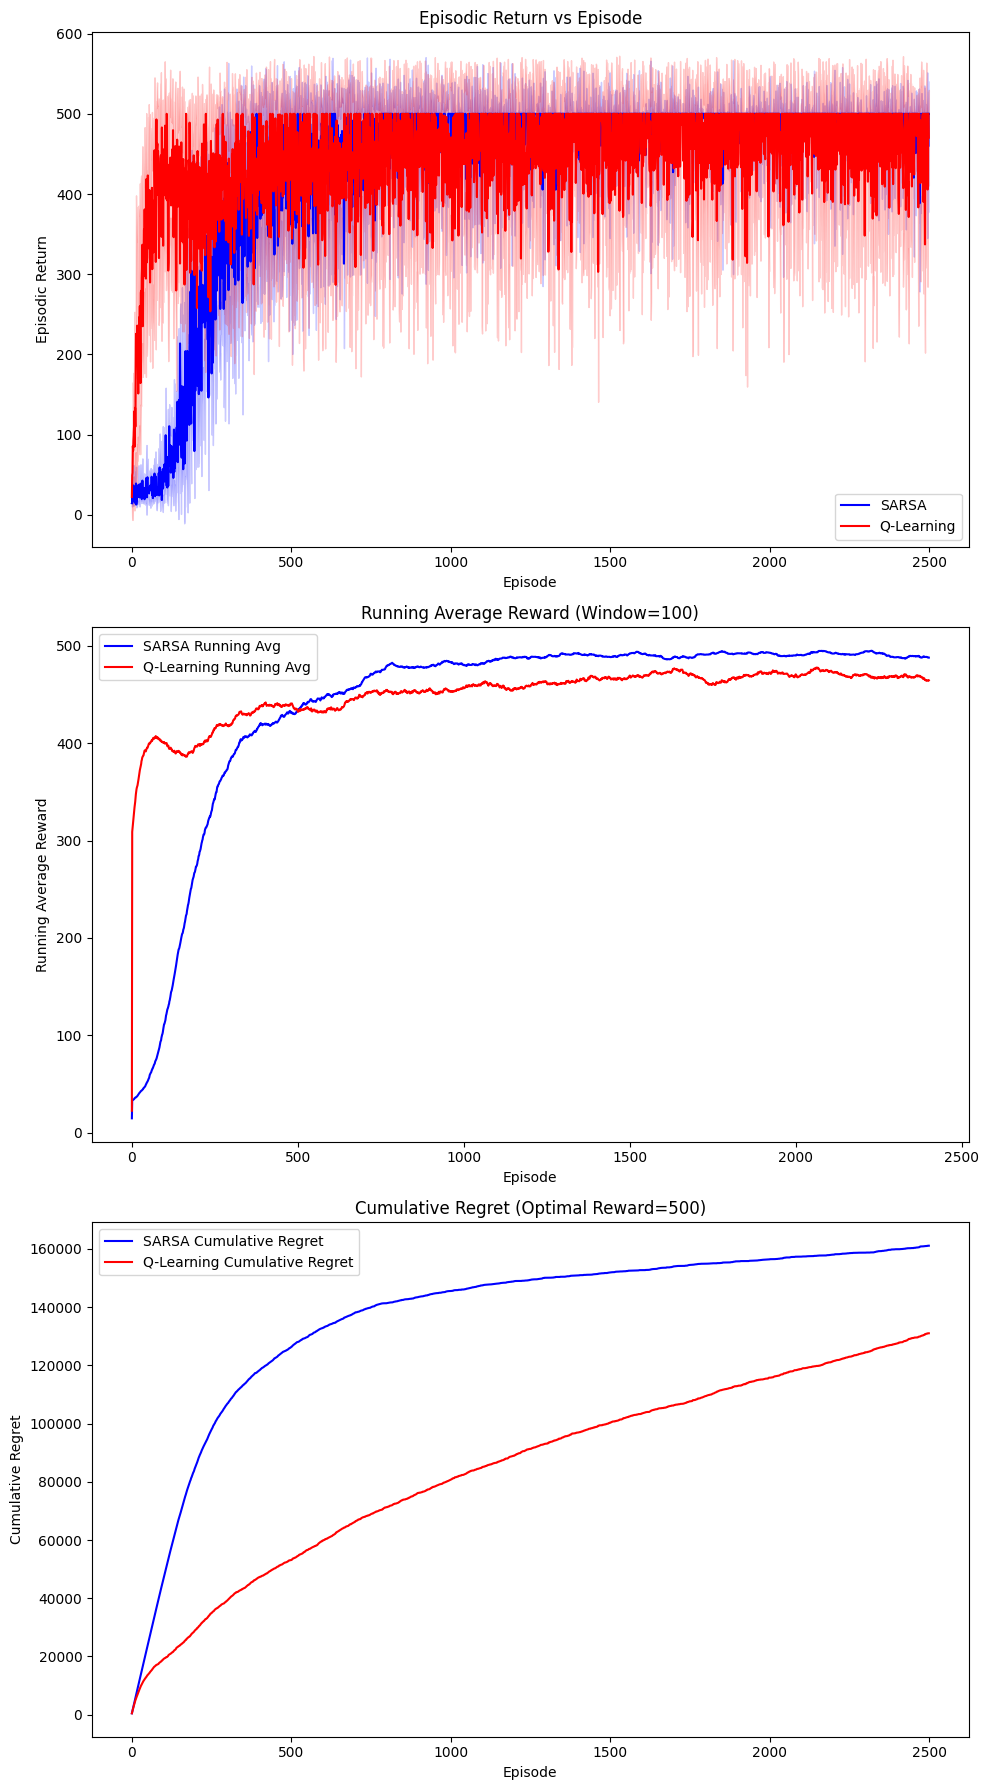

In [75]:
# Compute mean and standard deviation over seeds for each episode.
mean_rewards_sarsa = np.mean(sarsa_rewards, axis=0)
std_rewards_sarsa = np.std(sarsa_rewards, axis=0)
mean_rewards_qlearning = np.mean(qlearning_rewards, axis=0)
std_rewards_qlearning = np.std(qlearning_rewards, axis=0)

# Compute running averages (using a window of 100 episodes)
running_avg_sarsa = moving_average(mean_rewards_sarsa, window_size=100)
running_avg_qlearning = moving_average(mean_rewards_qlearning, window_size=100)

# Compute cumulative regret. We assume an optimal reward of 500 per episode.
optimal_reward = 500
instant_regret_sarsa = optimal_reward - mean_rewards_sarsa
cumulative_regret_sarsa = np.cumsum(instant_regret_sarsa)

instant_regret_qlearning = optimal_reward - mean_rewards_qlearning
cumulative_regret_qlearning = np.cumsum(instant_regret_qlearning)

episodes = np.arange(num_episodes)

# Plotting: We'll create 3 subplots:
# 1. Episodic Return vs Episode
# 2. Running Average Reward
# 3. Cumulative Regret

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# 1. Episodic Return
axs[0].plot(episodes, mean_rewards_sarsa, label="SARSA", color="blue")
axs[0].fill_between(episodes,
                    mean_rewards_sarsa - std_rewards_sarsa,
                    mean_rewards_sarsa + std_rewards_sarsa,
                    color="blue", alpha=0.2)
axs[0].plot(episodes, mean_rewards_qlearning, label="Q-Learning", color="red")
axs[0].fill_between(episodes,
                    mean_rewards_qlearning - std_rewards_qlearning,
                    mean_rewards_qlearning + std_rewards_qlearning,
                    color="red", alpha=0.2)
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Episodic Return")
axs[0].set_title("Episodic Return vs Episode")
axs[0].legend()

# 2. Running Average Reward
# Adjust x-axis for moving average (shorter by window_size - 1).
episodes_ma = np.arange(len(running_avg_sarsa))
axs[1].plot(episodes_ma, running_avg_sarsa, label="SARSA Running Avg", color="blue")
axs[1].plot(episodes_ma, running_avg_qlearning, label="Q-Learning Running Avg", color="red")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Running Average Reward")
axs[1].set_title("Running Average Reward (Window=100)")
axs[1].legend()

# 3. Cumulative Regret
axs[2].plot(episodes, cumulative_regret_sarsa, label="SARSA Cumulative Regret", color="blue")
axs[2].plot(episodes, cumulative_regret_qlearning, label="Q-Learning Cumulative Regret", color="red")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Cumulative Regret")
axs[2].set_title("Cumulative Regret (Optimal Reward=500)")
axs[2].legend()

plt.tight_layout()
plt.show()

Plots

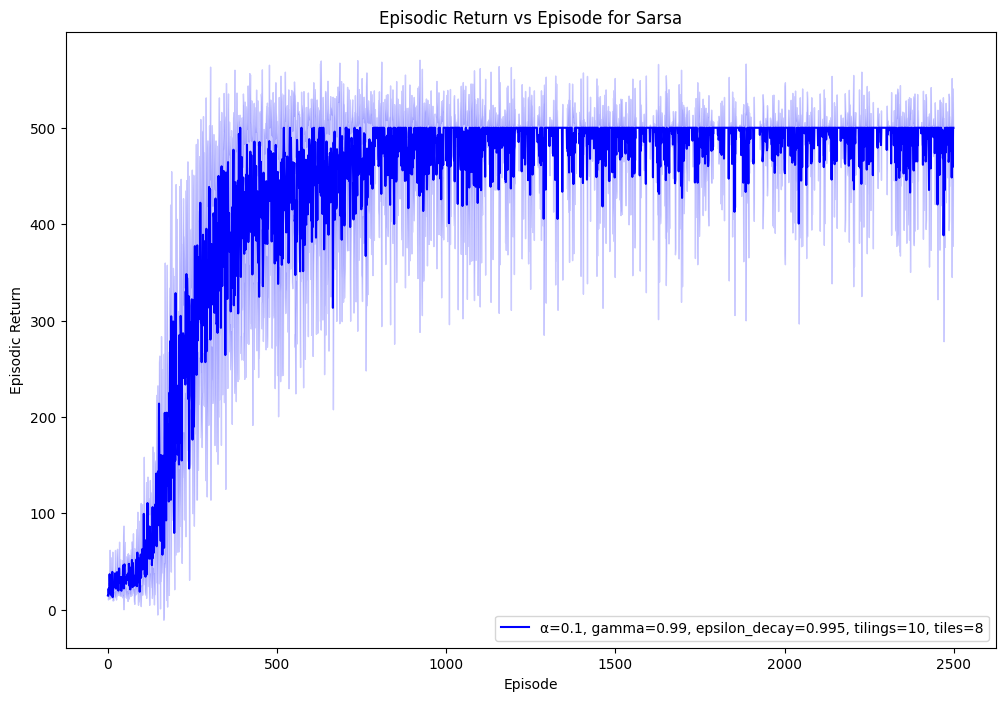

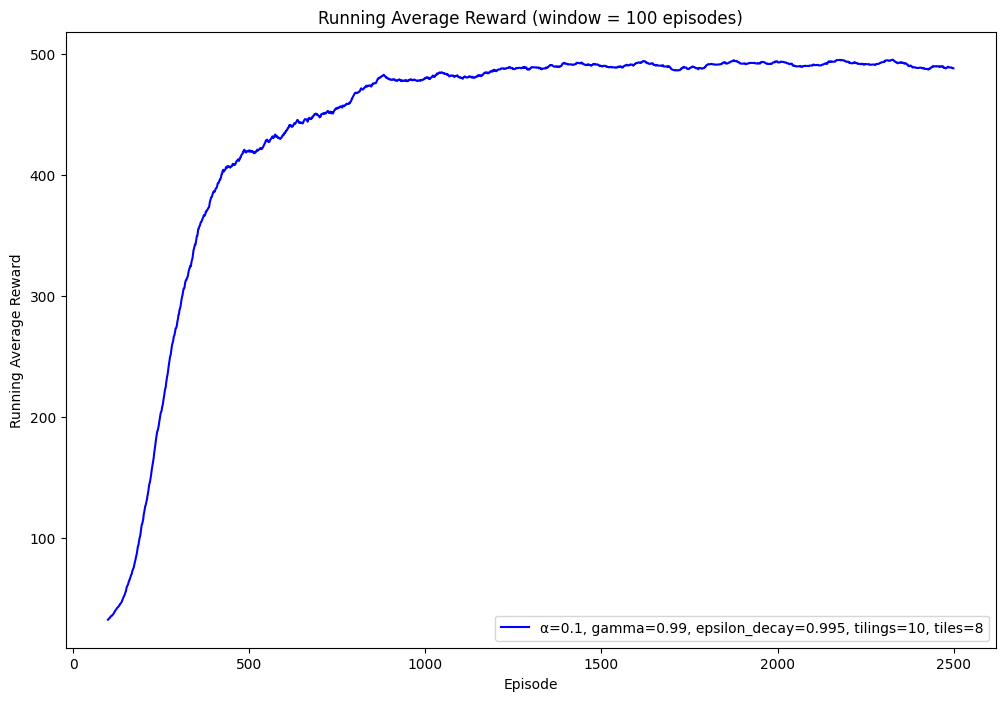

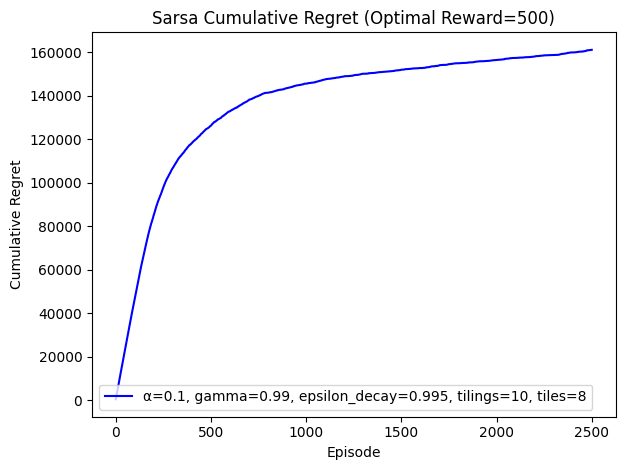

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Define legend labels for clarity (customize as needed)
labels = [
    "α=0.1, gamma=0.99, epsilon_decay=0.995, tilings=10, tiles=8",
    "α=0.05, gamma=0.99, epsilon_decay=0.995, tilings=10, tiles=8",
    "α=0.05, gamma=0.99, epsilon_decay=0.995, tilings=5, tiles=4",
    "α=0.05, gamma=0.99, epsilon_decay=0.995, tilings=5, tiles=2",
    "α=0.05, gamma=0.99, epsilon_decay=0.999, tilings=5, tiles=4"
]

colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each configuration

rewards = sarsa_rewards
plt.figure(figsize=(12, 8))
# Compute mean and std across seeds for each episode
mean_rewards = np.mean(rewards, axis=0)
std_rewards = np.std(rewards, axis=0)
episodes = np.arange(len(mean_rewards))

# Plot mean line
plt.plot(episodes, mean_rewards, color=colors[0], label=labels[0])
# Plot shaded region for mean ± std
plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards,
                  color=colors[0], alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Episodic Return")
plt.title("Episodic Return vs Episode for Sarsa")
plt.legend()
plt.show()


# Plot 2: Running Average Reward
window = 100
plt.figure(figsize=(12, 8))

rewards = sarsa_rewards
mean_rewards = np.mean(rewards, axis=0)

# Compute running average via convolution
running_avg = np.convolve(mean_rewards, np.ones(window)/window, mode='valid')

# Define episode indices correctly
episodes = np.arange(window - 1, len(mean_rewards))

# Plot
plt.plot(episodes, running_avg, color=colors[0], label=labels[0])
plt.xlabel("Episode")
plt.ylabel("Running Average Reward")
plt.title(f"Running Average Reward (window = {window} episodes)")
plt.legend()
plt.show()

# Plot 3: Cumulative Regret

#  We assume an optimal reward of 500 per episode.
optimal_reward = 500
rewards = sarsa_rewards

mean_rewards_sarsa = np.mean(rewards, axis=0)
instant_regret_sarsa = optimal_reward - mean_rewards_sarsa
cumulative_regret_sarsa = np.cumsum(instant_regret_sarsa)
episodes = np.arange(len(cumulative_regret_sarsa))

plt.plot(episodes, cumulative_regret_sarsa, label=labels[0], color="blue")
plt.xlabel("Episode")
plt.ylabel("Cumulative Regret")
plt.title("Sarsa Cumulative Regret (Optimal Reward=500)")
plt.legend()

plt.tight_layout()
plt.show()

Importing rewards from 2 other configs calculated in separate notebook.

In [52]:
sarsa_rewards_df = pd.read_excel("sarsa_rewards_4.xlsx")

# Convert back to NumPy array (removing "Seed" column)
sarsa_rewards_4 = sarsa_rewards_df.drop(columns=["Seed"]).values

print("Loaded SARSA rewards shape:", sarsa_rewards_4.shape)  # Should be (num_seeds, num_episodes)

Loaded SARSA rewards shape: (5, 2500)


In [76]:
sarsa_rewards_df = pd.read_excel("sarsa_rewards_5.xlsx")

# Convert back to NumPy array (removing "Seed" column)
sarsa_rewards_5 = sarsa_rewards_df.drop(columns=["Seed"]).values

print("Loaded SARSA rewards shape:", sarsa_rewards_5.shape)  # Should be (num_seeds, num_episodes)

Loaded SARSA rewards shape: (5, 2500)


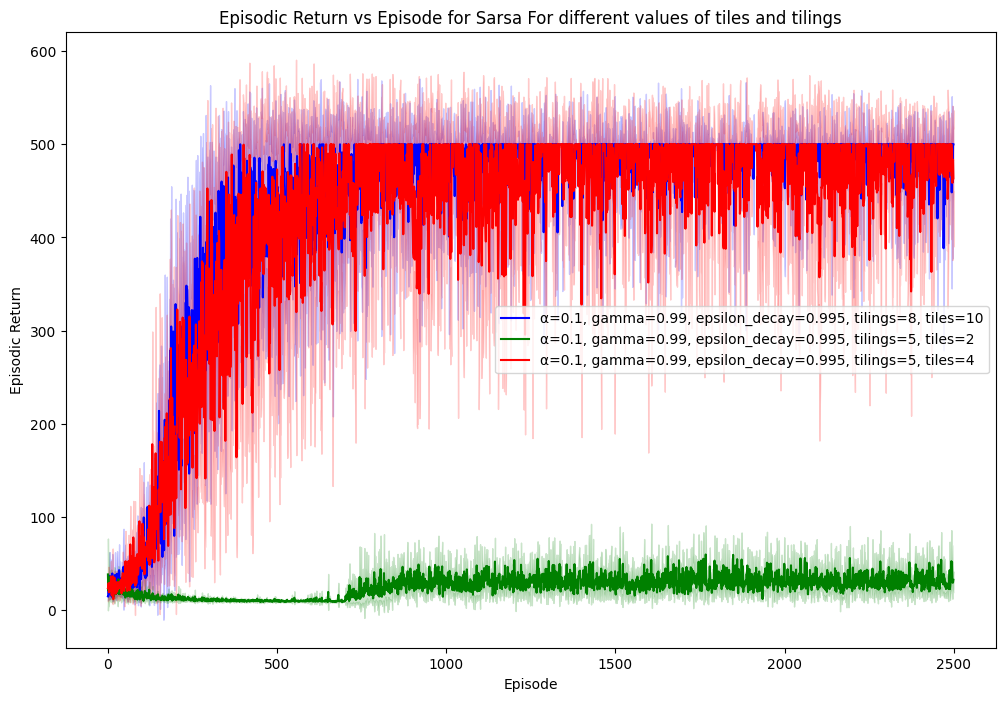

In [78]:
# plot for different values of tiles and tilings

qL1 = [sarsa_rewards,sarsa_rewards_4,sarsa_rewards_5]
plt.figure(figsize=(12, 8))
labels[1] = ["α=0.1, gamma=0.99, epsilon_decay=0.995, tilings=5, tiles=2"]
labels[2] = ["α=0.1, gamma=0.99, epsilon_decay=0.995, tilings=5, tiles=4"]

for i,rewards in enumerate(qL1):
  # Compute mean and std  across seeds for each episode
  mean_rewards = np.mean(rewards, axis=0)
  std_rewards = np.std(rewards, axis=0)
  episodes = np.arange(len(mean_rewards))

  # Plot mean line
  plt.plot(episodes, mean_rewards, color=colors[i], label=labels[i])
  # Plot shaded region for mean ± std
  plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards,
                    color=colors[i], alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Episodic Return")
plt.title("Episodic Return vs Episode for Sarsa For different values of tiles and tilings")
plt.legend()
plt.show()